# **Project Introduction**

## Problem Statement

Before football matches, there's often discussion about home field advantage, and until June 2021, knockout tournaments had the away goal rule in case of a tie after two legs. So how does the venue (home field or away field) affect the result (win, lose, draw) and the score of a match? Our project aims to answer this question.

## Hypothesis

Hypothesis:
* **H0:** *The "home field" factor does not affect a team's goal difference in a match.*
* **H1:** *The "home field" factor positively affects a team's goal difference in a match.*

## Implementation Steps

The implementation will include:

  1. **Scraping information (raw data) about matches from websites.**
  2. **Using LLMs to extract structured data from the raw scraped data.**
  3. **Using Causal Inference to test the hypothesis**

#**1. Web Scraping**

## 1.1 Implementation Tools

- **SELENIUM**
  + Selenium with Python is a toolkit and library that allows you to automate web browsers using Python.
  + Using Selenium with Python, you can write automation scripts to perform tasks such as controlling web browsers, interacting with web elements, entering data, and clicking as a user would interact with websites.
  + Since our project needs to sequentially and continuously extract data between matchday overviews and matchday reports, Selenium effectively supports page navigation and return operations. Additionally, the website contains JavaScript text that hides information in the HTML source, and Selenium supports JavaScript as it can simulate user behavior.
  + The downside of Selenium is that it runs slowly because it directly interacts with the browser like a user, consuming significant system resources.
- **HOW TO USE SELENIUM**
  + To use Selenium, you need to install Selenium with Python as follows: Open Command Prompt and type "pip install selenium".
  + Previously, you needed to install a webdriver corresponding to your browser, but this is no longer necessary. For example, to use Selenium, simply import webdriver and run webdriver.Chrome() to create a driver for Chrome.

## 1.2 Data Source Website

- Website homepage: https://www.transfermarkt.com
- Link to full matchday page (matchday overviews) (For France, Ligue 1): https://www.transfermarkt.com/ligue-1/spieltag/wettbewerb/FR1/saison_id/2023/spieltag/34
- Link to matchday report (first match in Season: 23/24, Matchday: 1.Matchday): https://www.transfermarkt.com/spielbericht/index/spielbericht/4094582
- Data will be collected from 4 countries: France, England, Germany, Spain, taking all matches from matchdays in the 5 most recent years with available match data.

## 1.3 Web Scraping Implementation

In [ ]:
# Import necessary libraries for web scraping
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver import ActionChains
from selenium.webdriver.remote.webelement import WebElement
import argparse
import time
import os
import json

In [ ]:
# Constants for web interaction
WAIT_TIME = 5
MAX_ERROR_TIMES = 5 # Number of retries when browsing, finding elements fails

# Chrome options to disable image loading for faster browsing
DEFAULT_CHROME_OPTIONS = webdriver.ChromeOptions()
PREFS = {"profile.managed_default_content_settings.images": 2}
DEFAULT_CHROME_OPTIONS.add_experimental_option("prefs", PREFS)

# Website homepage URL
HOME_PAGE = 'https://www.transfermarkt.com'

# URL components for creating links to full matchday page, format: "https://www.transfermarkt.com/{league code}/spieltag/wettbewerb/{country id}/saison_id"
MID_URL = 'spieltag/wettbewerb'
LAST_URL = 'saison_id'

# CSS selectors, ID names of elements in the page
TransfermarktWeb = {
    'id_popup_accept': 'sp_message_iframe_953358',
    'css_button_accept': 'button[title="Accept & continue"]',
    'css_quick_select_bar': 'tm-quick-select-bar.hydrated',
    'css_quick_select_in_shadow_root': 'tm-quick-select.hydrated',
    'css_list_tm_quick_select_item': 'div.selector-dropdown > ul > tm-quick-select-item.hydrated',
    'css_forward_button': 'a.forward-button',
    'css_button_show': 'tr > td > input[class="small button right"]',
    'css_sub_navigation': '',
    'css_box_table_select': 'table.auflistung > tbody > tr div.inline-select > div',
    'css_list_li_select': 'ul.chzn-results li',
    'css_matchday_overviews_boxs': 'div.box[style="border-top: 0 !important;"]',
    'css_matchday_infor_overview': 'table > tbody',
    'css_link_matchday_report': 'div.footer > a.liveLink',
    'css_lineup': 'main > div.row > div[class="large-12 columns"] > div.box > div.large-6',
    'css_lineup_name_team': 'a[class="sb-vereinslink"]',
    'css_starting_lineup': 'div.row div.aufstellung-unterueberschrift'
}

# Close popup that appears when first opening the website
def accept_cookies(driver:webdriver):
    time.sleep(3)
    try:
        while len(driver.find_elements(By.ID, TransfermarktWeb['id_popup_accept'])) > 0:
            driver.switch_to.frame(TransfermarktWeb['id_popup_accept'])
            button_accept = driver.find_element(By.CSS_SELECTOR, TransfermarktWeb['css_button_accept'])
            button_accept.click()
            time.sleep(3)
            driver.switch_to.default_content()
    except:
        raise ValueError("Can't close pop-up iframe to accept cookies")

# Scroll page to center the element in the viewport
def scroll_page_to_element(driver:webdriver, element:WebElement):
    try:
        driver.execute_script("arguments[0].scrollIntoView({block: 'center'});", element)
    except:
        raise ValueError('Scroll page to element error!')

In [ ]:
# Find the horizontal bar containing quick selection boxes (country, league, club, player)
def find_tm_quick_select_bar(driver:webdriver):
        try:
            return driver.find_element(By.CSS_SELECTOR, TransfermarktWeb['css_quick_select_bar'])
        except:
            raise ValueError('Find tm quick select bar error!')

# Get list of quick selection boxes
def get_list_select_boxs(driver:webdriver):
        tm_quick_select_bar = find_tm_quick_select_bar(driver)
        try:
            tm_quick_select_boxs = tm_quick_select_bar.shadow_root.find_elements(By.CSS_SELECTOR, TransfermarktWeb['css_quick_select_in_shadow_root'])
            return tm_quick_select_boxs
        except:
            raise ValueError('Get list select boxs error!')

# Get list of options in a quick selection box
def get_list_items_quick_select(contain_element):
    try:
        if contain_element.get_attribute('dropdown-visible') is None:
            contain_element.click()
        list_items = contain_element.find_elements(By.CSS_SELECTOR, TransfermarktWeb['css_list_tm_quick_select_item'])
        return list_items
    except:
        raise ValueError('Get list items error!')

# Select an option in quick selection box based on text content
def select_item_quick_select_by_content(contain_element, content):
    list_items = get_list_items_quick_select(contain_element)
    try:
        if contain_element.get_attribute('dropdown-visible') is None:
            list_items.click()
        for item in list_items:
            if content == item.text:
                item.click()
                break
        return contain_element.find_element(By.CSS_SELECTOR, TransfermarktWeb['css_forward_button']).get_attribute('href')
    except:
        raise ValueError('Select item by content error!')

# Select first option in quick selection box
def select_item_first(contain_element:WebElement):
    try:
        list_items = get_list_items_quick_select(contain_element)
        if contain_element.get_attribute('dropdown-visible') is None:
            list_items.click()
        list_items[0].click()
        return contain_element.find_element(By.CSS_SELECTOR, TransfermarktWeb['css_forward_button']).get_attribute('href')
    except:
        raise ValueError('Select first item get error!')

# Create URL to matchday table after selecting country and league
def get_url_to_matchday_table(driver:webdriver, name_country:str, wait=WAIT_TIME, max_error_times=MAX_ERROR_TIMES):
    error_times = 0
    while error_times < max_error_times:
        try:
            quick_select_boxs = get_list_select_boxs(driver)
            select_item_quick_select_by_content(quick_select_boxs[0], name_country)
            driver.implicitly_wait(wait)
            url = select_item_first(quick_select_boxs[1])
            url = url.split('/')
            return "/".join([HOME_PAGE,url[3],MID_URL,url[6],LAST_URL])
        except:
            error_times += 1
            driver.refresh()
            driver.implicitly_wait(wait)
    raise ValueError('Get url to matchday table false!')

# Navigate to full matchday page
def to_matchday_table(driver, url, wait=WAIT_TIME):
    driver.get(url)
    driver.implicitly_wait(wait)

In [ ]:
# Find filter selection boxes (season, matchday)
def get_filter_select_boxs(driver, max_error_times=MAX_ERROR_TIMES):
    error_times = 0
    while error_times < max_error_times:
        try:
            filter_select_boxs = driver.find_elements(By.CSS_SELECTOR, TransfermarktWeb['css_box_table_select'])
            return filter_select_boxs
        except:
            error_times += 1
            driver.refresh()

# Click show button to confirm filter selections
def submit_show(driver, wait=WAIT_TIME):
    try:
        driver.find_element(By.CSS_SELECTOR, TransfermarktWeb['css_button_show']).click()
        driver.implicitly_wait(wait)
    except:
        raise ValueError('Submit show error!')

# Get list of options inside a filter selection box
def get_list_items_filter_select(contain_element):
    try:
        if 'chzn-with-drop' not in contain_element.get_attribute('class'):
            contain_element.click()
        list_items = contain_element.find_elements(By.CSS_SELECTOR, TransfermarktWeb['css_list_li_select'])
        return list_items
    except:
        raise ValueError('Get list items error!')

# Select option in filter box based on text content
def select_item_filter_select_by_content(contain_element, content):
    list_items = get_list_items_filter_select(contain_element)
    try:
        if 'chzn-with-drop' not in contain_element.get_attribute('class'):
            contain_element.click()
        for item in list_items:
            if content == item.text:
                item.click()
                return
        contain_element.click()
    except:
        raise ValueError('Select item by content error!')

# Get list of match overview boxes in a matchday
def get_list_overviews_boxs(driver, wait=WAIT_TIME, max_error_times=MAX_ERROR_TIMES):
    error_times = 0
    while error_times < max_error_times:
        try:
            list_overviews_boxs = driver.find_elements(By.CSS_SELECTOR, TransfermarktWeb['css_matchday_overviews_boxs'])
            return list_overviews_boxs
        except:
            error_times += 1
            driver.refresh()
            driver.implicitly_wait(wait)
    raise ValueError('Get overviews boxs error!')

# Get list of URLs to match reports in a matchday
def get_urls_to_match_report(list_overviews_boxs):
    try:
        list_url = []
        for box in list_overviews_boxs:
            url = box.find_element(By.CSS_SELECTOR, TransfermarktWeb['css_link_matchday_report']).get_attribute('href')
            list_url.append(url)
        return list_url
    except:
        raise ValueError('Get url to match report error!')

# List of match overview information (team rankings, team names, score, attendance, referee...) in a matchday
def get_overviews_in_matchday(list_overviews_boxs):
    try:
        overviews = []
        for ovb in list_overviews_boxs:
            content_element = ovb.find_element(By.CSS_SELECTOR, TransfermarktWeb['css_matchday_infor_overview']).text
            overviews.append(content_element)
        return overviews
    except:
        raise ValueError('Get infor matchday error!')

# Get lineup information for each team in a match in a matchday
def get_lineups_in_matchday(driver, list_urls, wait=WAIT_TIME, max_error_times=MAX_ERROR_TIMES):
    error_time = 0
    while error_time < max_error_times:
        try:
            lineup_infors = []
            for url in list_urls:
                driver.get(url)
                lineup_element = driver.find_elements(By.CSS_SELECTOR, TransfermarktWeb['css_lineup'])
                for lue in lineup_element:
                    lineup = ''
                    try:
                        lineup += lue.find_element(By.CSS_SELECTOR, TransfermarktWeb['css_lineup_name_team']).text
                    except:
                        lineup += 'None'
                    lineup += '\n'
                    try:
                        lineup += lue.find_element(By.CSS_SELECTOR, TransfermarktWeb['css_starting_lineup']).text
                    except:
                        lineup += 'None'
                    lineup += '\n'
                    lineup_infors.append(lineup)
                driver.back()
                driver.implicitly_wait(wait)
            return lineup_infors
        except:
            error_time += 1
            driver.refresh()
            driver.implicitly_wait(wait)
            return ['None/nNone/n', 'None/nNone/n']
            # raise ValueError('Get lineup infor error!')

# List of match information (overview + lineups) in a matchday
def get_matchday_infor(driver):
    try:
        list_overviews_boxs = get_list_overviews_boxs(driver)
        overviews_content = get_overviews_in_matchday(list_overviews_boxs)
        list_urls = get_urls_to_match_report(list_overviews_boxs)
        lineup_infors = get_lineups_in_matchday(driver, list_urls)
        result = []
        for i in range(len(overviews_content)):
            result.append(overviews_content[i] + lineup_infors[2*i] + lineup_infors[2*i + 1])
        return result
    except:
        raise ValueError('Get matchday infor error!')

# Write data to JSON file
def write_to_json(file_name, data):
    if os.path.exists(file_name):
        with open(file_name, 'r') as f:
            old_data = json.load(f)
    else:
        old_data = {}
    old_data.update(data)
    with open(file_name, 'w') as f:
        json.dump(old_data, f, indent=4)

In [ ]:
# Select a season by content
def show_season_select_by_content(driver, content, wait=WAIT_TIME):
    filter_select_boxs = get_filter_select_boxs(driver)
    scroll_page_to_element(driver, filter_select_boxs[0])
    select_item_filter_select_by_content(filter_select_boxs[0], content)
    submit_show(driver, wait)

# Select a matchday by content
def show_matchday_select_by_content(driver, content, wait=WAIT_TIME):
    filter_select_boxs = get_filter_select_boxs(driver)
    scroll_page_to_element(driver, filter_select_boxs[1])
    select_item_filter_select_by_content(filter_select_boxs[1], content)
    submit_show(driver, wait)

# Get available seasons
def get_seasons_select(driver):
    filter_select_boxs = get_filter_select_boxs(driver)
    scroll_page_to_element(driver, filter_select_boxs[0])
    season_filter_select_boxs = get_list_items_filter_select(filter_select_boxs[0])
    return [ss.text for ss in season_filter_select_boxs]

# Get available matchdays
def get_matchdays_select(driver):
    filter_select_boxs = get_filter_select_boxs(driver)
    scroll_page_to_element(driver, filter_select_boxs[1])
    matchday_filter_select_boxs = get_list_items_filter_select(filter_select_boxs[1])
    return [ms.text for ms in matchday_filter_select_boxs]

# Scrape data for a country, including nseasons seasons skipping those in except_seasons, and save data to file_output in JSON format
def crawling(country_name, file_output, except_seasons=[], nseasons=5, wait=WAIT_TIME, max_error_times=MAX_ERROR_TIMES):
    driver = webdriver.Chrome(options=DEFAULT_CHROME_OPTIONS)
    driver.get(HOME_PAGE)
    accept_cookies(driver)
    url = get_url_to_matchday_table(driver, country_name, wait, max_error_times)
    to_matchday_table(driver, url, wait)
    seasons = get_seasons_select(driver)
    i = 0
    for ss in seasons:
        if i == nseasons:
            break
        if ss in except_seasons:
            continue
        i += 1
        show_season_select_by_content(driver, ss, wait)
        matchdays = get_matchdays_select(driver)
        for ms in matchdays:
            show_matchday_select_by_content(driver, ms, wait)
            matchday_infor = get_matchday_infor(driver)
            new_data = {}
            for ind, mi in enumerate(matchday_infor):
                new_data.update({f'{seasons[i]}-{ms}-{ind}': mi})
            write_to_json(file_output, new_data)
            print(f'{ss}-{ms}: Done')
    driver.quit()


In [ ]:
# Crawl data for French league (Ligue 1)
crawling('France', 'france.json', ['24/25', '2024'], 5)

In [ ]:
# Crawl data for English league (Premier League)
crawling('England', 'england.json', ['24/25', '2024'], 5)

In [ ]:
# Crawl data for German league (Bundesliga)
crawling('Germany', 'germany.json', ['24/25', '2024'], 5)

In [ ]:
# Crawl data for Spanish league (La Liga)
crawling('Spain', 'spain.json', ['24/25', '2024'], 5)

# **2. Using LLM to Extract Structured Data from Raw Scraped Data**

In [ ]:
# Some necessary libraries
import numpy as np
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from typing import Optional,Dict, TypedDict
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_community.llms import Anyscale
from langchain_core.prompts import PromptTemplate,ChatPromptTemplate, MessagesPlaceholder
from langchain.chains import LLMChain
from langchain_core.output_parsers import PydanticOutputParser
from langchain_core.messages import (
    AIMessage,
    HumanMessage,
    SystemMessage,
)
import os
import json
import pandas as pd


In [ ]:
ANYSCALE_API_BASE = "https://api.endpoints.anyscale.com/v1"
ANYSCALE_API_KEY = "esecret_xc3dx8e1de7hhi626wah26syul"
ANYSCALE_MODEL_NAME = "mistralai/Mixtral-8x22B-Instruct-v0.1"

# Set environment variables for Anyscale usage
os.environ["ANYSCALE_API_BASE"] = ANYSCALE_API_BASE
os.environ["ANYSCALE_API_KEY"] = ANYSCALE_API_KEY

## 2.1 Key Concepts

1. Langchain
2. LLM
3. Message
4. Prompt template
5. Chain
6. Output Parsers

### 1. Langchain

* LangChain is an open source framework built around large language models (LLMs) that allows developers to build applications based on these models.
* We will use Langchain to perform this part of the project.

### 2. LLM

* LLM - Large Language Model is a type of artificial intelligence model trained on vast amounts of text data to understand and generate natural language accurately.
* These models can perform various language tasks such as translation, text summarization, question answering, writing, and even literary composition.
* In this section, we will use it to extract structured data.
* LLMs accept input as strings and return output as strings, but Langchain allows us to pass message-type inputs which it formats into strings before passing to the model.
* Langchain doesn't own any models but relies on third-party providers like ChatOpenAI or HuggingFace.
* Here we will use a model via API.

In [ ]:
# Example of using a model with Langchain
# Here we use the Mixtral-8x22B-Instruct-v0.1 model from Anyscale
ANYSCALE_API_BASE = "https://api.endpoints.anyscale.com/v1"
ANYSCALE_API_KEY = "esecret_xc3dx8e1de7hhi626wah26syul"
ANYSCALE_MODEL_NAME = "mistralai/Mixtral-8x22B-Instruct-v0.1"

# Set environment variables for Anyscale usage
os.environ["ANYSCALE_API_BASE"] = ANYSCALE_API_BASE
os.environ["ANYSCALE_API_KEY"] = ANYSCALE_API_KEY

# Initialize the model
llm = Anyscale(model_name=ANYSCALE_MODEL_NAME,temperature=0.5)

# Send a query to the model
# invoke is the standard interface to call a chain on an input
# We'll learn more about chains later
# For now, treat this as sending a query to the model
respond=llm.invoke("Tell me a funny joke.")
print(respond)

 What do you call a blind dinosaur? Doyouthinkhesaurus!


### 3. Message

* As mentioned above, Langchain allows us to pass message-type inputs to an LLM, so what is a message?
* A message is a data type that works with ChatModels, with each message describing a conversation.
* Basically, a message has two main components:
    * role: describes who owns the message. Langchain has classes for different roles:
        * HumanMessage: represents a message from the user.
        * AIMessage: represents a message from the model.
        * SystemMessage: represents a message from the system, used to guide the model on how to respond to the user. Not all models support this type.
        * There are a few more roles, but these are the main ones we need.
    * content: describes the content of the message. There are two types of content: string type (used by most models) and a list of dictionaries.


### 4. Prompt template

* Prompt templates help convert user inputs and parameters into instructions for language models.
* They can be used to guide the model's response, helping it understand concepts and return relevant outputs.
* The input to Prompt Templates is a dictionary. Each key is the name of a variable in the prompt template that we fill in.
* The output of Prompt Templates is a PromptValue. A PromptValue can be passed to a language model and can be cast to a string or a list of messages.
* The reason for having PromptValue is to make it easy to switch between strings and messages.
* There are 3 types of Prompt Templates: String PromptTemplates, ChatPromptTemplates, and MessagesPlaceholder.

String PromptTemplates are typically used to format a single string and are commonly used for simple inputs.

In [ ]:
# create template, here the variable topic will be replaced with the value "cats"
prompt_template = PromptTemplate.from_template("Tell me a joke about {topic}")

prompt =prompt_template.invoke({"topic": "cats"})

prompt

StringPromptValue(text='Tell me a joke about cats')

ChatPromptTemplates: these prompt templates are typically used to format lists of messages. The prompt template itself includes other prompt templates.

In [ ]:
prompt_template = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful {job}"),
    ("user", "Tell me a joke about {topic}")
])

prompt=prompt_template.invoke({"topic": "cats", "job": "assistant"})

print("Print as message:")
print(prompt)

print("Print as string:")
print(prompt.to_string())

Print as message:
messages=[SystemMessage(content='You are a helpful assistant'), HumanMessage(content='Tell me a joke about cats')]
Print as string:
System: You are a helpful assistant
Human: Tell me a joke about cats


MessagesPlaceholder: This prompt template allows you to place a list of messages at a fixed position. This can be useful if you want to pass in a list of messages instead of a string.

In [ ]:
prompt_template = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful assistant"),
    MessagesPlaceholder("msgs")
])

prompt_template.invoke({"msgs": [HumanMessage(content="hi!")]})

print(prompt.to_string())

System: You are a helpful assistant
Human: Tell me a joke about cats


In [ ]:
# another way to use placeholder
prompt_template = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful assistant"),
    ("placeholder", "{msgs}")
])

prompt_template.invoke({"msgs": [HumanMessage(content="hi!")]})

print(prompt.to_string())


System: You are a helpful assistant
Human: Tell me a joke about cats


### 5. Chain

* When working with language models, sometimes there are complex tasks that require multiple steps.
* The input of each step is the processed output of the previous step.
* This sequence of steps is called a chain.
* Langchain helps us define and work with chains more easily.

As mentioned above, each PromptValue will be passed to the language model as an input. A simple way to do this is as follows:

In [ ]:
llm=Anyscale(model_name=ANYSCALE_MODEL_NAME,temperature=0.5)

# create a template
prompt_template = ChatPromptTemplate.from_messages([
    ("system",
      "You are a calculator."
      "You solve math problems the user asks you."),
    ("user", "{query}")
])

# create input
input=prompt_template.invoke({"query": "What is 2+2?")

# send input to the model and get the answer
respond=llm.invoke(input)
print(respond)


Assistant: The sum of 2 and 2 is 4.


As you can see, with the usual approach, even with just two steps, it is quite verbose. We can optimize the process by creating a chain to handle it.

In [ ]:
# select the model
llm=Anyscale(model_name=ANYSCALE_MODEL_NAME,temperature=0.5)

# create a template
prompt_template = ChatPromptTemplate.from_messages([
    ("system",
      "You are a calculator."
      "You solve math problems the user asks you."),
    ("user", "{query}")
])

# define the chain
chain = prompt_template | llm
# The above code creates a chain
# When we pass input to the chain, it is first processed by prompt_template to create a prompt
# Then that output is passed to the llm to get a response
# We use the "|" operator to connect steps in the chain
# and use invoke to call the chain on an input
# In previous examples, we used invoke on a single step because we treated it as a chain of one step

respond=chain.invoke({"query": "What is 2+2*8?"})
print(respond)


Assistant: The result is 18. According to the order of operations (PEMDAS/BODMAS), you should perform multiplication and division before addition and subtraction. So, 2 + (2*8) = 2 + 16 = 18.


chain : **prompt | llm** is the most basic chain

### 6. Output parsers

* Their task is to receive output from the model (in message or string format) and convert it to another type for subsequent processing steps.
* Useful for creating structured data by LLM or standardizing output from the language model.

* Langchain has many different types of output parsers such as JSON, CSV, Pydantic,... But here we will choose to use Pydantic output parsers because it is quite easy to use.

* Note: Nowadays, more and more models support returning structured output without using output parsers, but not all. So to be more general, we will use output parsers.

To use an output parser, we first need to create a schema, which is a framework containing the information to be extracted from the desired object.

The schema will be created by a class inheriting from the BaseModel class in the pydantic_v1 package.

In [ ]:
# We will create a schema for the Person object with basic information
# For each attribute (concept) defined in the Person class
# we must describe and explain it to the model via Field
# even explain the Person class in the docstring
# This description is important because it will be passed to the prompt_template
# to guide and help the model better understand the information to process and extract
# The better the description, the more accurate the extraction

class Person(BaseModel):
    """Information about a person."""
    name: Optional[str] = Field(description="The person's name.")
    age: Optional[int] = Field(description="The person's age.")

In [ ]:
# create a parser with the Person schema
parser = PydanticOutputParser(pydantic_object=Person)

# use get_instructions method to see the required input format
# this requirement will be passed to the prompt_template
print(parser.get_format_instructions())

The output should be formatted as a JSON instance that conforms to the JSON schema below.

As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}
the object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.

Here is the output schema:
```
{"description": "Information about a person.", "properties": {"name": {"title": "Name", "description": "The person's name.", "type": "string"}, "age": {"title": "Age", "description": "The person's age.", "type": "integer"}}}
```


In [ ]:
# now we will create the prompt_template
prompt=ChatPromptTemplate.from_messages([
    (
        "system",
        "You are an expert extraction algorithm."
        "Only extract relevant information from the text. "
        "If you do not know the value of an attribute asked to extract, "
        "check it one more time and if you still can't find it, "
        "return null for the attribute's value."
        "Answer the user query,"
        " Wrap the output in ```json tag\n{format_instructions}"
    ),
    ("user", "{query}")
]).partial(format_instructions=parser.get_format_instructions())

# print prompt templates
print(prompt.invoke({"query": ""}).to_string())

System: You are an expert extraction algorithm.Only extract relevant information from the text. If you do not know the value of an attribute asked to extract, check it one more time and if you still can't find it, return null for the attribute's value.Answer the user query, Wrap the output in ```json tag
The output should be formatted as a JSON instance that conforms to the JSON schema below.

As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}
the object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.

Here is the output schema:
```
{"description": "Information about a person.", "properties": {"name": {"title": "Name", "description": "The person's name.", "type": "string"}, "age": {"title": "Age", "description": "The person's age.", "type": "integer"}}}
```
Human: 


In [ ]:
llm=Anyscale(model_name=ANYSCALE_MODEL_NAME,temperature=0.5)

#create chain
chain=prompt|llm

# pass query to the chain
parser_input=chain.invoke({"query": "Eight-year-old Alex is an energetic boy who loves playing soccer"})

# pass the output of the chain to the parser
output=parser.parse(parser_input)
output

Person(name='Alex', age=8)

In [ ]:
# An easier way is to add the parser to the chain
chain=prompt|llm|parser
chain.invoke({"query": "John is 25 years old."})

Person(name='John', age=25)

## 2.2 Extract structured data from raw data

In [ ]:
file_names=['germany.json','france.json','spain.json','england.json']
raw_data = []
for file_name in file_names:
    with open(file_name) as f:
        # Load JSON data from file
        data = json.load(f)

    # Now data contains the data from the JSON file
    for i in data:
        raw_data.append(i.split('-')[1]+'\n'+data[i])

In [ ]:
print(raw_data[0])

1.Matchday
  (9.)  Werder Bremen 0:4 Bayern Munich  (3.)  
Friday, Aug 18, 2023  - 8:30 PM
  42.100 sold out  ·   Felix Zwayer
Course of play
    0:1 4'  Leroy Sané
    0:2 74'  Harry Kane
    0:3 90'  Leroy Sané
    0:4 90+4'  Mathys Tel
   Leroy Sané  - Score: 1.5
3.89 Average score 2.57
Who does the community think will win?
2.5 % 5.1 % 92.4 %
SV Werder Bremen
Starting Line-up: 3-1-4-2
Bayern Munich
Starting Line-up: 4-2-3-1



Each element of raw_data is the information of a match.

Each match includes both the home and away teams.

But what we want to extract is the match information for each team.

So we will do as follows:

* First, extract the information for each match (including both home and away teams).
    
* Store in a dataframe, perform preprocessing steps.

* Split each match into two records for the home and away teams.

### 1. Extract match information from raw data

Create a Match class with some attributes to extract as follows:

* matchday_order (int): The order of the matchday in the season
* home_team (string): name of the home team
* home_team_position (int): rank of the home team before the match
* home_team_score (int): number of goals scored by the home team in the match
* home_team_starting_lineup (string): starting lineup of the home team
* away_team (string): name of the away team
* away_team_position (int): rank of the away team before the match
* away_team_score (int): number of goals scored by the away team in the match
* away_team_starting_lineup (string): starting lineup of the away team
* comunity_prediction_home_team_win (float): community prediction percentage for home team win
* comunity_prediction_away_team_win (float): community prediction percentage for away team win
* comunity_prediction_draw (float): community prediction percentage for draw
* date (string): date of the match
* referee (string): name of the referee

*Note: The data we input is not a clear sentence describing the above attributes, but rather information arranged in a table format that only those familiar with the field can interpret. Therefore, when describing, in addition to explaining what the attribute is, we will also explain where that attribute appears.*

E.g.: the first team name is the home team, ...

In [ ]:
# Create schema for Match
class Match(BaseModel):
    """Information about a match between Hometeam and Awayteam."""
    matchday_order: Optional[int] = Field(default=None, description="The order of the matchday in the season, the number occurs in the beginning of the line.")
    home_team: Optional[str] = Field(default=None, description="The name of the team that occurs first.")
    home_team_position: Optional[int] = Field(default=None, description="The number in the round bracket in front of the home team name and in the beginning of the line contains both home team name and away team name, show the position in rank of home team.")
    home_team_score: Optional[int] = Field(default=None, description="The number that occurs right after the home team name, show the score of home team.")
    away_team: Optional[str] = Field(default=None, description="The name of the team that occurs second.")
    away_team_position: Optional[int] = Field(default=None, description="The number in the round bracket in right after the away team and in the end of the line contains both home team name and away team name, show the position in rank of away team.")
    away_team_score: Optional[int] = Field(default=None, description="The number that occurs in front of the away team name, show the score of away team.")
    home_team_starting_lineup: Optional[str] = Field(default=None, description="The information of the home team line up , is the line up occurs first.ONLY include the numbers")
    away_team_starting_lineup: Optional[str] = Field(default=None, description="The information of the away team line up , is the line up occurs second.ONLY include the numbers")
    comunity_prediction_home_team_win: Optional[float] = Field(default=None, description="the first number in the comunity prediction, show the percentage of the home team win, usually goes with %%.")
    comunity_prediction_draw: Optional[float] = Field(default=None, description="the second number in the comunity prediction, show the percentage of the draw,  usually goes with %%.")
    comunity_prediction_away_team_win: Optional[float] = Field(default=None, description="the third number in the comunity prediction, show the percentage of the away team win, usually goes with %%.")
    date: Optional[str] = Field(default=None, description="The date of the match, the date occurs in the line bellow of home team name, NOT includes time.Convert to dd/mm/yyyy format.")
    referee: Optional[str] = Field(default=None, description="The name of the referee, the name occurs in the line bellow of the line containing date and time.")

Create an output parser to extract Match

In [ ]:
parser=PydanticOutputParser(pydantic_object=Match)

Create a prompt template, pay close attention to the instructions

In [ ]:
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an expert extraction algorithm in a football match. "
            "Only extract relevant information from the text."
            "Return null for the attribute's values you can't find."
            "Don't make up the information if you can't find it."
            "Answer the user query.NO NEED TO PRINT 'AI:' IN OUTPUT. Wrap the output in ```json tag\n{format_instructions}",
        ),

        # use placeholder so we can pass examples to the model
        # having some sample conversations in advance
        # will help improve the model's performance
        # for example, help identify and extract information better
        # reduce output format errors when passing to the parser
        MessagesPlaceholder("example"),
        ("user", "{query}"),
    ]
).partial(format_instructions=parser.get_format_instructions())

Select the model. As mentioned above, here we use the *Mixtral-8x22B-Instruct-v0.1* model from Anyscale. You can use another model, but you will need to adjust the *prompt templates* accordingly.

In [ ]:
llm=Anyscale(model_name=ANYSCALE_MODEL_NAME,temperature=0.0)

Create a chain with the order: *prompt -> llm -> parser*

In [ ]:
chain=prompt | llm | parser

Next, we will create some necessary functions:
* Function to create examples
* Function to save the attributes of a Match object to a dictionary for creating a dataframe

Function to create examples

In [ ]:
# Create Example class to define the structure of an example
# An example contains a query and an output
# query is the input to be passed
# output is the correct Match object that the chain should return
class Example(TypedDict):
    query: str
    output: Match

# function to convert an Example object into messages to pass to the prompt template
def convert_example_into_message(Example):
    query = Example["query"]
    output = Example["output"]
    matchday_order= "null" if output.matchday_order is None else output.matchday_order
    home_team= "null" if output.home_team is None else f' "{output.home_team}" '
    home_team_position= "null" if output.home_team_position is None else output.home_team_position
    home_team_score= "null" if output.home_team_score is None else output.home_team_score
    away_team= "null" if output.away_team is None else f' "{output.away_team}" '
    away_team_position= "null" if output.away_team_position is None else output.away_team_position
    away_team_score= "null" if output.away_team_score is None else output.away_team_score
    home_team_starting_lineup= "null" if output.home_team_starting_lineup is None else f' "{output.home_team_starting_lineup}" '
    away_team_starting_lineup= "null" if output.away_team_starting_lineup is None else f' "{output.away_team_starting_lineup}" '
    comunity_prediction_home_team_win= "null" if output.comunity_prediction_home_team_win is None else output.comunity_prediction_home_team_win
    comunity_prediction_draw= "null" if output.comunity_prediction_draw is None else output.comunity_prediction_draw
    comunity_prediction_away_team_win= "null" if output.comunity_prediction_away_team_win is None else output.comunity_prediction_away_team_win
    date= "null" if output.date is None else f' "{output.date}" '
    referee= "null" if output.referee is None else f' "{output.referee}" '
    ai_ouptut_=f"""
        "matchday_order": {matchday_order},
        "home_team": {home_team},
        "home_team_position": {home_team_position},
        "home_team_score": {home_team_score},
        "away_team": {away_team},
        "away_team_position": {away_team_position},
        "away_team_score": {away_team_score},
        "home_team_starting_lineup": {home_team_starting_lineup},
        "away_team_starting_lineup": {away_team_starting_lineup},
        "comunity_prediction_home_team_win": {comunity_prediction_home_team_win},
        "comunity_prediction_draw": {comunity_prediction_draw},
        "comunity_prediction_away_team_win": {comunity_prediction_away_team_win},
        "date": {date},
        "referee": {referee}
    """
    ai_ouptut="\n ```json\n{"+ai_ouptut_+"}\n```"
    return [("user", query), ("ai", ai_ouptut)]

Function to save information from the Match object to a dictionary

In [ ]:
# Check if the returned Match object is missing any attributes
# If so, return False
def check_extracted_data_is_not_null(respond):
    if respond.matchday_order is None or respond.home_team is None or respond.home_team_position is None or respond.home_team_score is None or respond.away_team is None or respond.away_team_position is None or respond.away_team_score is None or respond.home_team_starting_lineup is None or respond.away_team_starting_lineup is None or respond.comunity_prediction_home_team_win is None or respond.comunity_prediction_draw is None or respond.comunity_prediction_away_team_win is None or respond.referee is None  or respond.date is None :
        return False
    return True

# Function to save information from respond to Extracted_Data
# respond is the Match object returned from the chain
def store_data_from_respond(Extracted_Data,respond):
    Extracted_Data["Matchday order"].append(respond.matchday_order)
    Extracted_Data["Home team"].append(respond.home_team)
    Extracted_Data["Home team position"].append(respond.home_team_position)
    Extracted_Data["Home team score"].append(respond.home_team_score)
    Extracted_Data["Away team"].append(respond.away_team)
    Extracted_Data["Away team position"].append(respond.away_team_position)
    Extracted_Data["Away team score"].append(respond.away_team_score)
    Extracted_Data["Home team starting lineup"].append(respond.home_team_starting_lineup)
    Extracted_Data["Away team starting lineup"].append(respond.away_team_starting_lineup)
    Extracted_Data["Comunity prediction home team win"].append(respond.comunity_prediction_home_team_win)
    Extracted_Data["Comunity prediction draw"].append(respond.comunity_prediction_draw)
    Extracted_Data["Comunity prediction away team win"].append(respond.comunity_prediction_away_team_win)
    Extracted_Data["Date"].append(respond.date)
    Extracted_Data["Referee"].append(respond.referee)

Create a set of Examples, here we will use 5 examples

In [ ]:
example_set=[
  Example(
    query="""
12.Matchday
(15.)  FC Augsburg 2:1 1.FSV Mainz 05  (18.)
Saturday, Sep 23, 2023  - 3:30 PM
 22.012 sold out  ·   Marco Fritz
Course of play
    0:1 6'  Ludovic Ajorque
Ermedin Demirovic  15' 1:1
Ermedin Demirovic  45' 2:1
Arne Engels  62'
   Ermedin Demirovic  - Score: 2.1
3.48 Average score 3.87
Who does the community think will win?
47.2 % 40.1 % 12.6 %
FC Augsburg
Starting Line-up: 3-4-2-1
1.FSV Mainz 05
Starting Line-up: 3-4-2-1
""",
    output=Match(matchday_order=12, home_team='FC Augsburg', home_team_position=15, home_team_score=2, away_team='1.FSV Mainz 05', away_team_position=18, away_team_score=1, home_team_starting_lineup='3-4-2-1', away_team_starting_lineup='3-4-2-1', comunity_prediction_home_team_win=47.2, comunity_prediction_draw=40.1, comunity_prediction_away_team_win=12.6, date='23/09/2023', referee='Marco Fritz')
),
Example(
    query="""
1.Matchday
(17.)  Arm. Bielefeld 2:1 1.FSV Mainz 05  (16.)
Saturday, Dec 5, 2020  - 3:30 PM
 Marco Fritz
Course of play
Manuel Prietl  21' 1:0
Ritsu Doan  31' 2:0
    2:1 82'  Kevin Stöger
   Ritsu Doan  - Score: 1.8
2.98 Average score 3.72
Who does the community think will win?
34.2 % 35.3 % 30.5 %
Arminia Bielefeld
Starting Line-up: 4-4-2 double 6
1.FSV Mainz 05
Starting Line-up: 3-4-2-1
""",
output=Match(matchday_order=1,home_team='Arminia Bielefeld', home_team_position=17, home_team_score=2, away_team='1.FSV Mainz 05', away_team_position=16, away_team_score=1, home_team_starting_lineup='4-4-2 double 6', away_team_starting_lineup='3-4-2-1', comunity_prediction_home_team_win=34.2, comunity_prediction_draw=35.3, comunity_prediction_away_team_win=30.5, date='05/12/2020', referee='Marco Fritz')
),
Example(
    query="""21.Matchday
  (13.)  Bor. M'gladbach 0:0 Darmstadt 98  (18.)
Saturday, Feb 10, 2024  - 3:30 PM
  46.121  ·
   Marcel Schuhen  - Score: 2.2
3.61 Average score 3.38
Who does the community think will win?
94.8 % 3.4 % 1.8 %
Borussia Mönchengladbach
Starting Line-up: 3-5-2 flat
SV Darmstadt 98
Starting Line-up: 3-4-1-2""",
    output=Match(matchday_order=21, home_team='Borussia Mönchengladbach', home_team_position=13, home_team_score=0, away_team='Darmstadt 98', away_team_position=18, away_team_score=0, home_team_starting_lineup='3-5-2 flat', away_team_starting_lineup='3-4-1-2', comunity_prediction_home_team_win=94.8, comunity_prediction_draw=3.4, comunity_prediction_away_team_win=1.8, date='10/02/2024', referee=None)
  ),
Example(
    query="""29.Matchday
(4.)  Stade Rennais 6:1 FC Metz  (19.)
Sunday, Mar 20, 2022  - 3:00 PM
  27.966  ·   Willy Delajod
Course of play
Martin Terrier  18' 1:0
Martin Terrier  27' 2:0
Serhou Guirassy  40' 3:0
Serhou Guirassy  54' 4:0
Hamari Traoré  58' 5:0
Serhou Guirassy  64' 6:0
    6:1 87'  Louis Mafouta
Who does the community think will win?
96.3 % 3.7 % 0.0 %
Stade Rennais FC
Starting Line-up: 4-3-3 Attacking
FC Metz
Starting Line-up: 3-4-3 """,
    output=Match(matchday_order=29, home_team='Stade Rennais', home_team_position=4, home_team_score=6, away_team='FC Metz', away_team_position=19, away_team_score=1, home_team_starting_lineup='4-3-3 Attacking', away_team_starting_lineup='3-4-3', comunity_prediction_home_team_win=96.3, comunity_prediction_draw=3.7, comunity_prediction_away_team_win=0.0, date='20/03/2022', referee='Willy Delajod')
  ),
Example(
    query=""" 31.Matchday
(10.)  FC Schalke 04 postponed B. Leverkusen  (5.)
Sunday, Jun 14, 2020  - 6:00 PM
 Daniel Siebert
Course of play
Daniel Caligiuri  51' 1:0
    1:1 81'  Juan Miranda
   Sven Bender  - Score: 2.6
3.53 Average score 3.64
Who does the community think will win?
6.3 % 7.3 % 86.4 %
FC Schalke 04
Starting Line-up: 4-4-2 double 6
Bayer 04 Leverkusen
Starting Line-up: 4-2-3-1""",
output=Match(matchday_order=31, home_team='FC Schalke 04', home_team_position=10, home_team_score=None, away_team='B. Leverkusen', away_team_position=5, away_team_score=None, home_team_starting_lineup='4-4-2 double 6', away_team_starting_lineup='4-2-3-1', comunity_prediction_home_team_win=6.3, comunity_prediction_draw=7.3, comunity_prediction_away_team_win=86.4, date='14/06/2020', referee='Daniel Siebert')
),
Example(
    query=""" 20.Matchday
  (5.)  Atlético Madrid postponed Rayo Vallecano  (11.)
Wednesday, Jan 31, 2024  - 9:00 PM
  47.003  ·   César Soto Grado
Course of play
Reinildo Mandava  35' 1:0
    1:1 42'  Álvaro García
Memphis Depay  90' 2:1
Atlético de Madrid
Starting Line-up: 3-5-2 flat
Rayo Vallecano
Starting Line-up: 3-4-2-1""",
output=Match(matchday_order=20, home_team='Atlético Madrid', home_team_position=5, home_team_score=None, away_team='Rayo Vallecano', away_team_position=11, away_team_score=None, home_team_starting_lineup='3-5-2 flat', away_team_starting_lineup='3-4-2-1', comunity_prediction_home_team_win=None, comunity_prediction_draw=None, comunity_prediction_away_team_win=None, date='31/01/2024', referee='César Soto Grado')
)
]

Convert the set of Examples into a list of messages

In [ ]:
messages = []
for example in example_set:
    messages.extend(convert_example_into_message(example))

Create a Dictionary to store data

In [ ]:
Extracted_Data={
    "Matchday order": [],
    "Home team": [],
    "Home team position": [],
    "Home team score": [],
    "Away team": [],
    "Away team position": [],
    "Away team score": [],
    "Home team starting lineup": [],
    "Away team starting lineup": [],
    "Comunity prediction home team win": [],
    "Comunity prediction draw": [],
    "Comunity prediction away team win": [],
    "Date": [],
    "Referee": []
}

Start extracting on the entire raw_data

In [ ]:
# max_retry is the maximum number of retries when encountering errors
# If exceeding max_retry, we accept the object (if unable to determine the attribute)
# or skip processing that data (if llm outputs the wrong format causing the parser to fail to create a Match object)
# Usually, there will be some cases where the model cannot extract information
# First, due to format errors (prompt not good enough or model's "intelligence")
# This can be fixed by retrying a few times, usually 1-2 times
# Second, the model cannot determine the attribute of the input and returns that attribute as None
# There are two reasons for this:
# 1. The input lacks that information, e.g. the match is postponed, so there is no score
# 2. The model cannot determine the information
# The second case, like the format error, can be fixed by retrying

Cannot_extract=0
Cannot_extract_data=[]
Cannot_find_value=0
Cannot_find_value_data=[]
max_retry=2
retry=0
total=len(raw_data)
i=0
while i < total:
    print("Processing input ",i,end="")
    try:
        respond = chain.invoke({"query": raw_data[i], "example": messages})
        if check_extracted_data_is_not_null(respond):
            store_data_from_respond(Extracted_Data,respond)
            # progress notification
            print("-----> Complete ----> %.2f %%"  %((i+1)/total*100))
            retry=0
        else:
            if retry<max_retry:
                i-=1
                retry+=1
            else:
                 Cannot_find_value_data.append(raw_data[i])
                 Cannot_find_value+=1
                 store_data_from_respond(Extracted_Data,respond)

    except Exception as e:
        if retry<max_retry:
                i-=1
                retry+=1
        else:
             Cannot_extract_data.append(raw_data[i])
             Cannot_extract+=1
    i+=1

Save data to dataframe

In [ ]:
df=pd.DataFrame(Extracted_Data)

# save data to a CSV file named Extracted_Data.csv
df.to_csv("Extracted_Data.csv",index=False)

Some data processing steps

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7055 entries, 0 to 7054
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Matchday order                     7055 non-null   int64  
 1   Home team                          7055 non-null   object 
 2   Home team position                 7055 non-null   int64  
 3   Home team score                    7046 non-null   float64
 4   Away team                          7055 non-null   object 
 5   Away team position                 7055 non-null   int64  
 6   Away team score                    7046 non-null   float64
 7   Home team starting lineup          7055 non-null   object 
 8   Away team starting lineup          7055 non-null   object 
 9   Comunity prediction home team win  7053 non-null   float64
 10  Comunity prediction draw           7053 non-null   float64
 11  Comunity prediction away team win  7053 non-null   float

In general, the attributes (columns) in the dataframe are the attributes of the Match class and have been explained above

Handle missing values

In [ ]:
num_rows_with_none = df.isnull().any(axis=1).sum()
print("Number of rows having None value: %d" %num_rows_with_none)
print("Percentage of missing: %.2f %%" %(num_rows_with_none/len(df)*100))

Number of rows having None value: 17
Percentage of missing: 0.24 %


As can be seen, the rate of missing data is very small, so for simplicity, we will remove rows with missing data.

In [ ]:
df.dropna(inplace=True)

In [ ]:
df.isnull().sum()

Matchday order                       0
Home team                            0
Home team position                   0
Home team score                      0
Away team                            0
Away team position                   0
Away team score                      0
Home team starting lineup            0
Away team starting lineup            0
Comunity prediction home team win    0
Comunity prediction draw             0
Comunity prediction away team win    0
Date                                 0
Referee                              0
dtype: int64

Save the dataframe to a file for storage and use

In [ ]:
df.to_csv("Extracted_Data.csv",index=False)

### 2. Split match information for each team

We will create a class called TeamMatch representing a team's match.

The attributes of TeamMatch are as follows:
* **matchday_order (string)**: order of the round in the season
* **date (string)**: date of the match
* **team_name (string)**: team name
* **pitch (['Away','Home'])**: Home or Away
* **position (int)**: team's ranking before the match
* **position_of_opponent (string)**: opponent's ranking
* **starting_line_up (string)**: team's tactical formation
* **starting_line_up_opponent (string)**: opponent's tactical formation
* **win_vote (float)**: community win prediction percentage for the team
* **draw_vote (float)**: community draw prediction percentage for the team
* **referee (string)**: referee's name
* **result (['Win','Draw','Lose'])**: match result
* **difference_of_score (int)**: score difference = team_score - opponent_score

In [ ]:
class TeamMatch:
  def __init__(self,matchday_order,date,team_name,pitch,position,position_of_opponent, starting_line_up,starting_line_up_opponent,win_vote,draw_vote,referee,result,difference_of_score):
    self.matchday_order = matchday_order
    self.date = date
    self.team_name = team_name
    self.pitch = pitch
    self.position = position
    self.position_of_opponent = position_of_opponent
    self.starting_line_up = starting_line_up
    self.starting_line_up_opponent = starting_line_up_opponent
    self.win_vote = win_vote
    self.draw_vote = draw_vote
    self.referee = referee
    self.result = result
    self.difference_of_score = difference_of_score

Start splitting TeamMatch objects

In [ ]:
df=pd.read_csv('Extracted_Data.csv')

In [ ]:
# create an array Data to store TeamMatch objects
Data=[]

# Iterate through each row of the dataframe and extract the necessary information to create TeamMatch objects
# Each row will yield two TeamMatch objects
for index, row in df.iterrows():
    home_team_difference_score=row['Home team score']-row['Away team score']
    home_team_result='Win' if home_team_difference_score>0 else 'Draw' if home_team_difference_score==0 else 'Lose'
    away_team_difference_score=row['Away team score']-row['Home team score']
    away_team_result='Win' if away_team_difference_score>0 else 'Draw' if away_team_difference_score==0 else 'Lose'

    HomeTeam=TeamMatch(matchday_order=row['Matchday order'],team_name=row['Home team'],
                       date=row['Date'],
                       pitch='Home',
                       position=row['Home team position'],
                       position_of_opponent=row['Away team position'],
                       starting_line_up=row['Home team starting lineup'],
                       starting_line_up_opponent=row['Away team starting lineup'],
                       win_vote=row['Comunity prediction home team win'],
                       draw_vote=row['Comunity prediction draw'],
                       referee=row['Referee'],
                       result=home_team_result,
                       difference_of_score=home_team_difference_score
                       )
    AwayTeam=TeamMatch(matchday_order=row['Matchday order'],team_name=row['Away team'],
                       date=row['Date'],
                       pitch='Away',
                       position=row['Away team position'],
                       position_of_opponent=row['Home team position'],
                       starting_line_up=row['Away team starting lineup'],
                       starting_line_up_opponent=row['Home team starting lineup'],
                       win_vote=row['Comunity prediction away team win'],
                       draw_vote=row['Comunity prediction draw'],
                       referee=row['Referee'],
                       result=away_team_result,
                       difference_of_score=away_team_difference_score
                       )
    Data.append(HomeTeam)
    Data.append(AwayTeam)

Save the attributes of TeamMatch objects to a dictionary and then create a dataframe

In [ ]:
# create a dictionary
TeamMatch_Data={
    "Matchday order":[],
    "Date":[],
    "Team name":[],
    "Pitch":[],
    "Position":[],
    "Position of opponent":[],
    "Starting line up":[],
    "Starting line up opponent":[],
    "Win vote":[],
    "Draw vote":[],
    "Referee":[],
    "Result":[],
    "Difference of score":[]
}

# save information from Data to TeamMatch_Data
for data in Data:
  TeamMatch_Data['Matchday order'].append(data.matchday_order)
  TeamMatch_Data['Date'].append(data.date)
  TeamMatch_Data['Team name'].append(data.team_name)
  TeamMatch_Data['Pitch'].append(data.pitch)
  TeamMatch_Data['Position'].append(data.position)
  TeamMatch_Data['Position of opponent'].append(data.position_of_opponent)
  TeamMatch_Data['Starting line up'].append(data.starting_line_up)
  TeamMatch_Data['Starting line up opponent'].append(data.starting_line_up_opponent)
  TeamMatch_Data['Win vote'].append(data.win_vote)
  TeamMatch_Data['Draw vote'].append(data.draw_vote)
  TeamMatch_Data['Referee'].append(data.referee)
  TeamMatch_Data['Result'].append(data.result)
  TeamMatch_Data['Difference of score'].append(data.difference_of_score)

In [ ]:
# create dataframe from TeamMatch_Data
dataframe=pd.DataFrame(TeamMatch_Data)

In [ ]:
dataframe.head(5)

,Matchday order,Date,Team name,Pitch,Position,Position of opponent,Starting line up,Starting line up opponent,Win vote,Draw vote,Referee,Result,Difference of score
0,1,18/08/2023,Werder Bremen,Home,9,3,3-1-4-2,4-2-3-1,2.5,5.1,Felix Zwayer,Lose,-4.0
1,1,18/08/2023,Bayern Munich,Away,3,9,4-2-3-1,3-1-4-2,92.4,5.1,Felix Zwayer,Win,4.0
2,1,19/08/2023,VfB Stuttgart,Home,2,16,4-2-3-1,5-4-1,77.4,17.5,Daniel Siebert,Win,5.0
3,1,19/08/2023,VfL Bochum,Away,16,2,5-4-1,4-2-3-1,5.1,17.5,Daniel Siebert,Lose,-5.0
4,1,19/08/2023,FC Augsburg,Home,11,14,4-4-2 double 6,4-2-3-1,16.2,26.1,Daniel Schlager,Draw,0.0


In [ ]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14076 entries, 0 to 14075
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Matchday order             14076 non-null  int64  
 1   Date                       14076 non-null  object 
 2   Team name                  14076 non-null  object 
 3   Pitch                      14076 non-null  object 
 4   Position                   14076 non-null  int64  
 5   Position of opponent       14076 non-null  int64  
 6   Starting line up           14076 non-null  object 
 7   Starting line up opponent  14076 non-null  object 
 8   Win vote                   14076 non-null  float64
 9   Draw vote                  14076 non-null  float64
 10  Referee                    14076 non-null  object 
 11  Result                     14076 non-null  object 
 12  Difference of score        14076 non-null  float64
dtypes: float64(3), int64(3), object(7)
memory usag

In [ ]:
dataframe.isnull().sum()

Matchday order               0
Date                         0
Team name                    0
Pitch                        0
Position                     0
Position of opponent         0
Starting line up             0
Starting line up opponent    0
Win vote                     0
Draw vote                    0
Referee                      0
Result                       0
Difference of score          0
dtype: int64

So we have completed the step of extracting structured data from raw_data, now just save the dataframe to a file for later use

In [ ]:
dataframe.to_csv('Extracted_Data_Updated.csv',index=False)

#**3. Using Causal Inference to Test the Hypothesis**

In [ ]:
# import necessary libraries
import numpy as np
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.linear_model import LogisticRegression
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib

## 3.1 Data Exploration

In [ ]:
df = pd.read_csv('Extracted_Data_Updated.csv')

In [ ]:
df

,Matchday order,Date,Team name,Pitch,Position,Position of opponent,Starting line up,Starting line up opponent,Win vote,Draw vote,Referee,Result,Difference of score
0,1,18/08/2023,Werder Bremen,Home,9,3,3-1-4-2,4-2-3-1,2.5,5.1,Felix Zwayer,Lose,-4.0
1,1,18/08/2023,Bayern Munich,Away,3,9,4-2-3-1,3-1-4-2,92.4,5.1,Felix Zwayer,Win,4.0
2,1,19/08/2023,VfB Stuttgart,Home,2,16,4-2-3-1,5-4-1,77.4,17.5,Daniel Siebert,Win,5.0
3,1,19/08/2023,VfL Bochum,Away,16,2,5-4-1,4-2-3-1,5.1,17.5,Daniel Siebert,Lose,-5.0
4,1,19/08/2023,FC Augsburg,Home,11,14,4-4-2 double 6,4-2-3-1,16.2,26.1,Daniel Schlager,Draw,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14071,38,26/07/2020,Brighton,Away,16,9,3-4-1-2,4-4-2,3.7,19.9,Jonathan Moss,Win,1.0
14072,38,26/07/2020,Man City,Home,2,20,4-1-4-1,4-2-3-1,100.0,0.0,Craig Pawson,Win,5.0
14073,38,26/07/2020,Norwich,Away,20,2,4-2-3-1,4-1-4-1,0.0,0.0,Craig Pawson,Lose,-5.0
14074,38,26/07/2020,Crystal Palace,Home,14,7,4-4-2,4-2-3-1,4.4,10.3,Andre Marriner,Draw,0.0


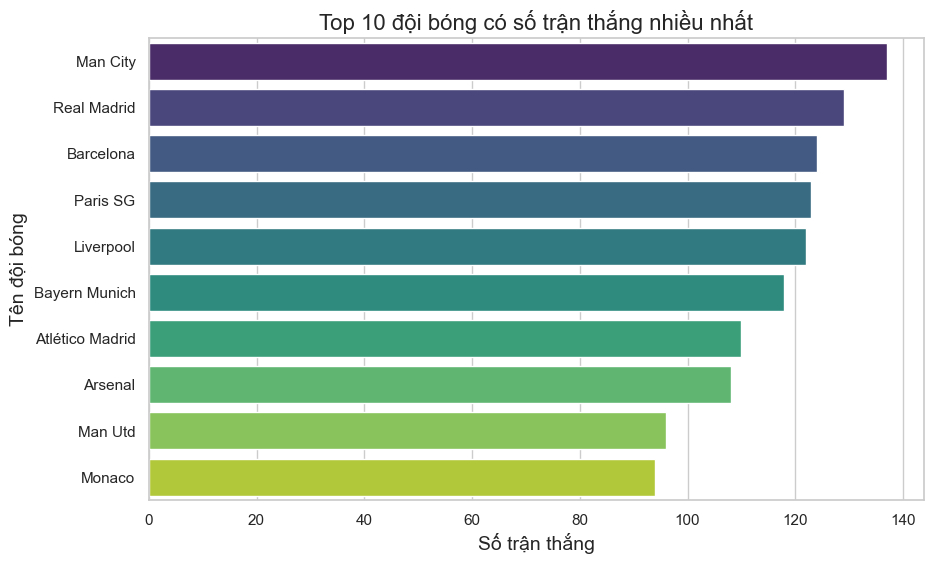

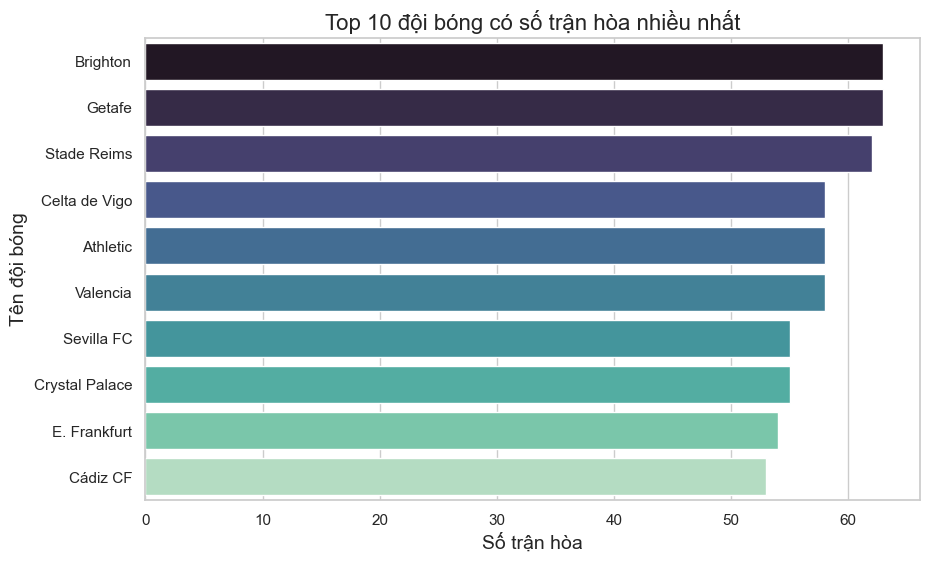

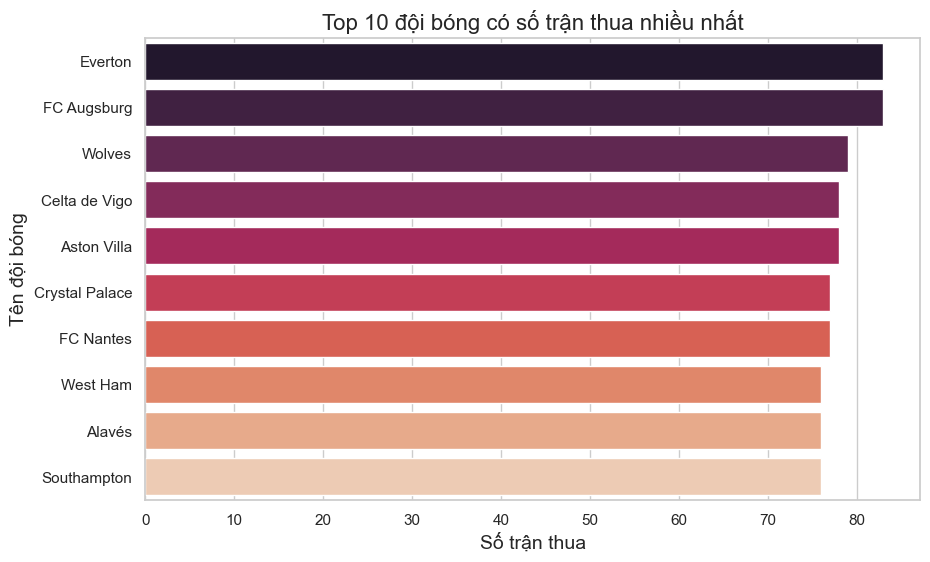

In [ ]:
# Visualize total wins, draws, losses
win_counts = df[df['Result'] == 'Win']['Team name'].value_counts().head(10)
draw_counts = df[df['Result'] == 'Draw']['Team name'].value_counts().head(10)
loss_counts = df[df['Result'] == 'Lose']['Team name'].value_counts().head(10)
win_df = win_counts.reset_index()
win_df.columns = ['Team name', 'Win Count']

draw_df = draw_counts.reset_index()
draw_df.columns = ['Team name', 'Draw Count']

loss_df = loss_counts.reset_index()
loss_df.columns = ['Team name', 'Loss Count']

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.barplot(data=win_df, y='Team name', x='Win Count', palette='viridis')
plt.title('Top 10 teams with the most wins', fontsize=16)
plt.xlabel('Number of wins', fontsize=14)
plt.ylabel('Team name', fontsize=14)
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(data=draw_df, y='Team name', x='Draw Count', palette='mako')
plt.title('Top 10 teams with the most draws', fontsize=16)
plt.xlabel('Number of draws', fontsize=14)
plt.ylabel('Team name', fontsize=14)
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(data=loss_df, y='Team name', x='Loss Count', palette='rocket')
plt.title('Top 10 teams with the most losses', fontsize=16)
plt.xlabel('Number of losses', fontsize=14)
plt.ylabel('Team name', fontsize=14)
plt.show()

**From the visualization of the teams with the most wins, we see that these are all strong teams with a rich history and tradition in Europe, such as: Barcelona, Mancity, Arsenal, Atlético Madrid, Paris SG, Liverpool, Bayern Munich, Monaco, Man Utd, Real Madrid**  


**The teams with the most losses are generally average compared to the overall level in Europe and most are currently playing in the English Premier League: Everton, FC Augsburg, Wolves, Celta de Vigo, Aston Villa, Crystal Palace, FC Nantes, West Ham, Alavés, Southampton.**

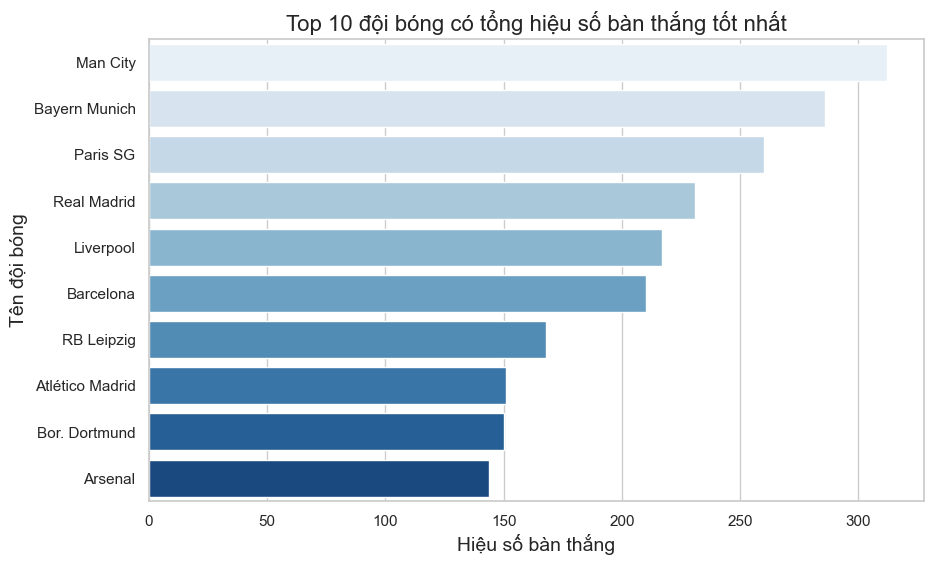

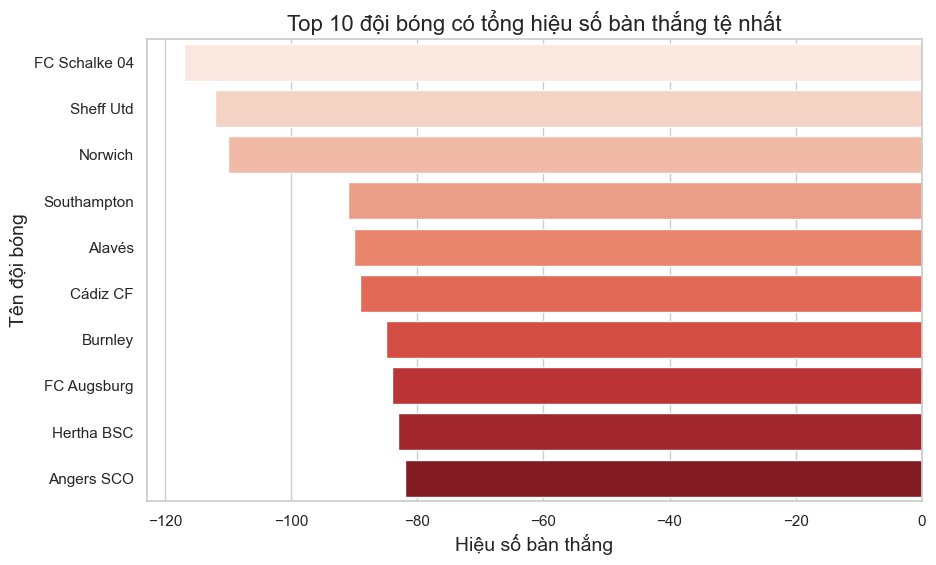

In [ ]:
# Calculate total goal difference for each team
goal_difference = df.groupby('Team name')['Difference of score'].sum().reset_index()

# Get the top 10 teams with the best goal difference
best_goal_difference = goal_difference.nlargest(10, 'Difference of score')

# Get the top 10 teams with the worst goal difference
worst_goal_difference = goal_difference.nsmallest(10, 'Difference of score')

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.barplot(data=best_goal_difference, y='Team name', x='Difference of score', palette='Blues')
plt.title('Top 10 teams with the best total goal difference', fontsize=16)
plt.xlabel('Goal difference', fontsize=14)
plt.ylabel('Team name', fontsize=14)
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(data=worst_goal_difference, y='Team name', x='Difference of score', palette='Reds')
plt.title('Top 10 teams with the worst total goal difference', fontsize=16)
plt.xlabel('Goal difference', fontsize=14)
plt.ylabel('Team name', fontsize=14)
plt.show()

**The team with the best total goal difference is Man City in the English Premier League**   
**The team with the worst total goal difference is FC Schalke 04, which is currently relegated and playing in the second division of Germany**


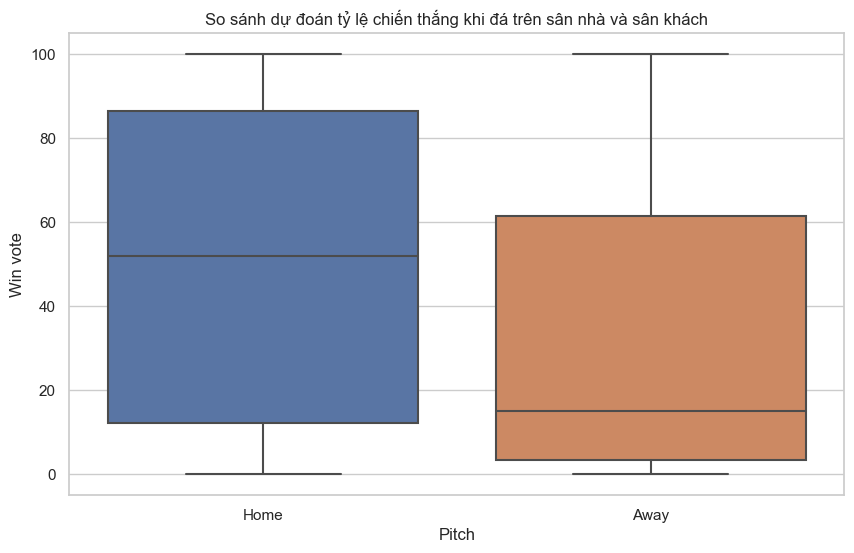

In [ ]:
# draw a boxplot of the win prediction percentage
plt.figure(figsize=(10, 6))
sns.boxplot(x='Pitch', y='Win vote', data=df)
plt.title('Comparison of win prediction percentage when playing at home and away')
plt.xlabel('Pitch')
plt.ylabel('Win vote')
plt.show()

**Playing at home is usually predicted with a higher win percentage than playing away**

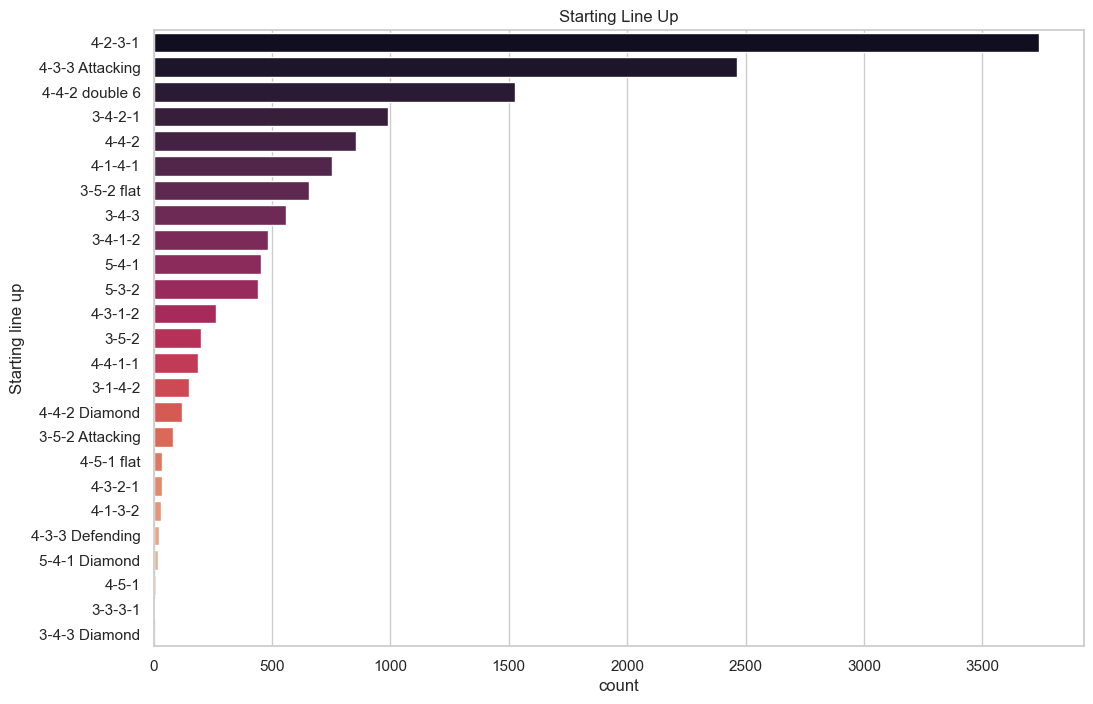

In [ ]:
# tactical formations
plt.figure(figsize=(12, 8))
sns.countplot(y='Starting line up', data=df, order=df['Starting line up'].value_counts().index,  palette='rocket')
plt.title('Starting Line Up')
plt.show()

**We see that the 4-2-3-1 formation is the most popular and chosen by coaches the most**
>The 4-2-3-1 football formation (also known as the diamond formation) was the choice of coach Jose Mourinho for Chelsea in the 2014-2015 season. In this return to lead Chelsea, he immediately won the Premier League title.  
This diamond formation combines the finesse in attack of the 4-4-2 formation and maximizes the strength and technique of the midfield in the 4-3-3 formation. It is strong in attack but still maintains stability in defense.

**The 4-2-3-1 formation uses personnel including: Four defenders, two defensive midfielders, three attacking midfielders, and one forward. It uses the strength of the diamond formation in the midfield, while successfully addressing the weakness of not having any player needing to move too wide.**

In [ ]:
df['Win vote'].describe()

count    14076.000000
mean        40.987006
std         35.864294
min          0.000000
25%          6.000000
50%         29.700000
75%         78.200000
max        100.000000
Name: Win vote, dtype: float64

**Min:** 0%  
**Max:** 100%  
This shows that these are likely matches between very strong teams in the league (top teams) and very weak teams in the league (bottom teams)

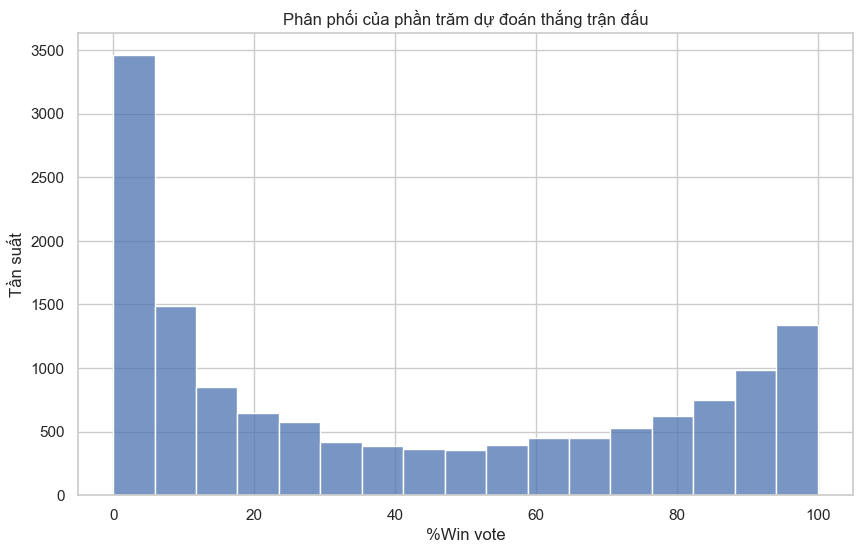

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(x='Win vote', data=df)
plt.title('Distribution of win prediction percentage')
plt.xlabel('%Win vote')
plt.ylabel('Frequency')
plt.show()

**Uneven distribution:** The distribution of win prediction percentage is uneven.


**High win prediction percentage (close to 100%):**

* Strong teams at the top of the rankings often have high win prediction percentages. This reflects high expectations from fans and experts about their chances of winning.

* The second peak in the histogram, located at a win prediction percentage of 100%, may represent strong teams. These teams often have stable performance, strong squads, and frequently win matches.

* Strong teams not only have many high win predictions (100%), but also have many values in the range of 70% to 90%. This shows high confidence from predictors about their chances of winning.


**Low win prediction percentage (close to 0%):**

* Weak teams at the bottom often have low win prediction percentages. This reflects a lack of confidence from fans and experts about their chances of winning.

* The highest peak in the histogram, located at a win prediction percentage of 0%, may represent weak teams. These teams often have unstable performance, weaker squads, and frequently lose matches.

* Weak teams not only have many low win predictions (0%), but also have many values in the range of 0% to 30%. This shows a lack of confidence from predictors about their chances of winning.

## 3.2 Features Engineering


In [ ]:
# drop unnecessary attributes
df = df.drop(columns=['Team name', 'Result'], axis = 0)

In [ ]:
# Only extract the month from the "Date" column to know when in the season the match took place
# Convert the "Date" column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

# Extract the month from the "Date" column
df['Month'] = df['Date'].dt.month

# Drop the "Date" column
df.drop(columns=['Date'], inplace=True)

In [ ]:
# feature scaling
num = ['Win vote', 'Draw vote']
scaler = StandardScaler()
df[num] =scaler.fit_transform(df[num])

In [ ]:
# feature encoding
# encode the treatment variable (T), T = 1: home, T = 0: away
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['Pitch'] = le.fit_transform(df['Pitch'])

In [ ]:
# convert categorical variables to dummy variables
categ = ['Matchday order','Position','Position of opponent','Starting line up', 'Starting line up opponent', 'Referee', 'Month']

data = pd.concat([
    df.drop(columns=categ),
    pd.get_dummies(df[categ], columns=categ, drop_first=False) # convert categorical to dummies
], axis=1)

print(data.shape)

(14076, 281)


## 3.3 Research Design

**Data type:** Observational data from matches in 4 national leagues: Germany, England, France, Spain, in the last 5 years. This is not a randomized experiment. The number of observed samples is: 14076 samples

**Allocation process of treatment and control groups:** The process of receiving treatment (playing at home) is exogenous, divided from the beginning of the season, and with the nature of a football league: when team A meets team B for the first time in the season, if team A plays at home, the next time they meet, team A will have to play away (at team B's home).

**Experimental situation:** The experimental situation does not have self-selection into treatment. There is no unobserved attribute correlated with treatment (playing at home or away) and outcome. But the data is split from a match, so the number of observations in the two groups will be equal, and the goal difference of the two observations split from a match will be opposite.

**Model:** From the above information, the group decided to use the matching model to build counterfactuals for the treatment and control groups. The goal is to ensure balance between the two groups. Then estimate the average treatment effect by the difference in outcomes of the two groups:
>**ATT = E(Yi(1)|T=1) - E(Yi(0)|T=1) (Average Treatment Effect on the Treated)    
   ATC = E(Yi(1)|T=0) - E(Yi(0)|T=0)  (Average Treatment Effect on the Control)**
* Where T is the treatment variable, Y is the dependent variable, and X is the covariates

**Method:** Use the propensity score matching (PSM) method to find the treatment group and control group that are similar in the overall sample using statistical models.

In this study: The propensity score is the probability of receiving treatment for an observation. It is the probability of a team playing at home.

## 3.4 Implement PSM - Propensity score matching

### 3.4.1 Calculate propensity scores and check the common support region

In [ ]:
# Estimate propensity scores using LogisticRegression
def estimate_propensity_scores(df, X, T):
    model = LogisticRegression(max_iter=1000)
    model.fit(df[X], df[T])
    propensity_scores = model.predict_proba(df[X])[:, 1] # get the probability of receiving treatment (label 1)
    return propensity_scores

# Perform matching between treatment and control groups based on propensity score
# build counterfactual for control group
def match_control_on_propensity_scores(df, propensity_scores, T):
    df['propensity_score'] = propensity_scores  # Assign propensity_score column to the original dataframe

    treated = df[df[T] == 1].copy()
    control = df[df[T] == 0].copy()

    matched_treated_indices = []

    for index, row in control.iterrows():
        if control.empty:
            break
        # Find the treated subject with the closest propensity score
        closest_index = np.argmin(np.abs(treated['propensity_score'] - row['propensity_score']))
        matched_treated_indices.append(treated.iloc[closest_index].name)

    matched_treated = df.loc[matched_treated_indices]
    matched_control = control

    return matched_treated, matched_control
# build counterfactual for treated group
def match_treated_on_propensity_scores(df, propensity_scores, T):
    df['propensity_score'] = propensity_scores  # Assign propensity_score column to the original dataframe

    treated = df[df[T] == 1].copy()
    control = df[df[T] == 0].copy()

    matched_control_indices = []

    for index, row in treated.iterrows():
        if treated.empty:
            break
        # Find the control subject with the closest propensity score
        closest_index = np.argmin(np.abs(control['propensity_score'] - row['propensity_score']))
        matched_control_indices.append(control.iloc[closest_index].name)

    matched_control = df.loc[matched_control_indices]
    matched_treated = treated

    return matched_treated, matched_control


# Calculate average treatment effect
def calculate_ate_from_matched(matched_treated, matched_control, Y):
   return np.mean(matched_treated[Y]) - np.mean(matched_control[Y])

In [ ]:
# Identify treatment variable (T), dependent variable (Y), and covariates (X).
T = 'Pitch'
Y = 'Difference of score'
X = data.columns.drop([T, Y])

In [ ]:
# Estimate Propensity Scores
propensity_scores = estimate_propensity_scores(data, X, T)

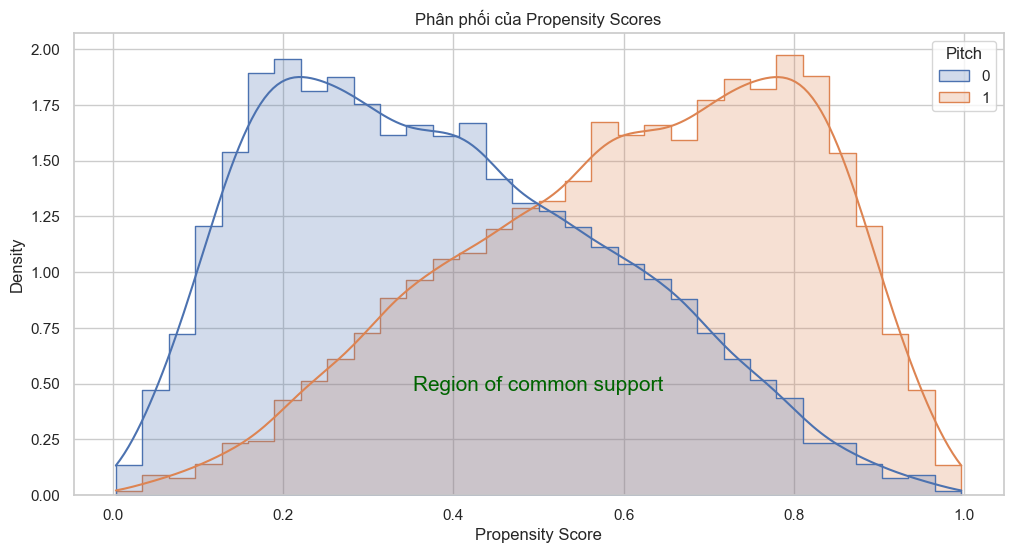

In [ ]:
# Distribution plot of propensity scores for the two groups
propensity_score = pd.DataFrame(propensity_scores, columns=['propensity_score'])
logic = pd.concat([propensity_score, data[T]], axis=1)
sns.set(style="whitegrid")
# Create a distribution plot for Propensity Scores
plt.figure(figsize=(12, 6))
sns.histplot(data=logic, x ='propensity_score', hue=T, element='step', stat='density', common_norm=False, kde=True)
plt.title('Distribution of Propensity Scores')
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.text(0.5, 0.47, 'Region of common support', fontsize=15, color='darkgreen', ha='center')
plt.show()

**We see that there is a common support region, and the common support region is large, covering, so it will ensure finding pairs of treated and control with similar propensity scores**

>**So we can continue to apply PSM.**

### 3.4.2 Build counterfactual for the treated group (playing at home)

In [ ]:
#Match observations
matched_treated, matched_control = match_treated_on_propensity_scores(data, propensity_scores, T)

In [ ]:
# Check how many different observations in the control group can be matched with 7027 observations in the treated group
unique_df = matched_control.drop_duplicates()
num_unique_rows = unique_df.shape[0]

print("Observations:", num_unique_rows)

Observations: 2956


#### Review the Quality of Matching

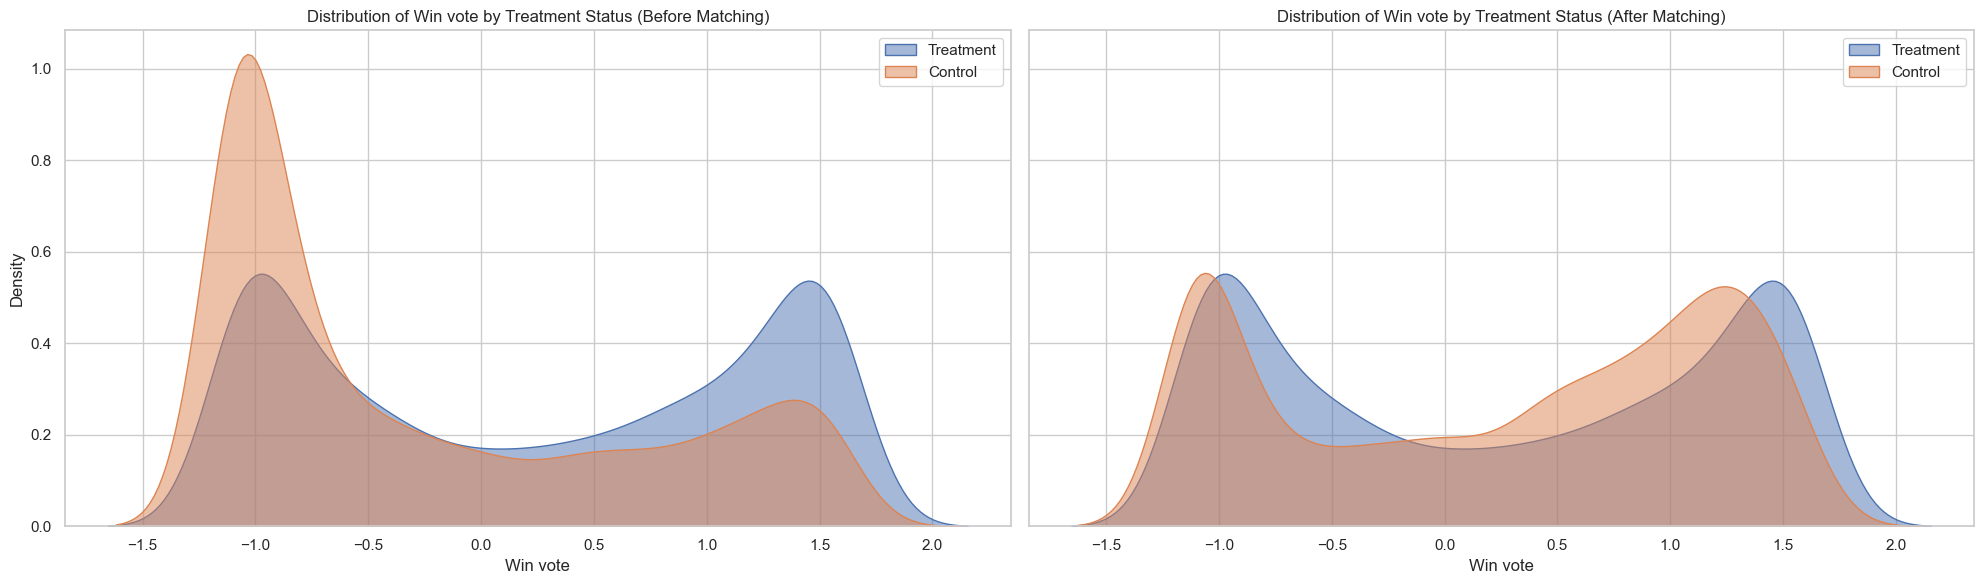

In [ ]:
numeric_vars = ['Win vote']

for var in numeric_vars:
    fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharey=True)

    # Data before matching
    sns.kdeplot(data[data['Pitch'] == 1][var], label='Treatment', fill=True, alpha=0.5, ax=axes[0])
    sns.kdeplot(data[data['Pitch'] == 0][var], label='Control', fill=True, alpha=0.5, ax=axes[0])
    axes[0].set_title(f'Distribution of {var} by Treatment Status (Before Matching)')
    axes[0].set_xlabel(var)
    axes[0].set_ylabel('Density')
    axes[0].legend()

    # Data after matching
    sns.kdeplot(matched_treated[var], label='Treatment', fill=True, alpha=0.5, ax=axes[1])
    sns.kdeplot(matched_control[var], label='Control', fill=True, alpha=0.5, ax=axes[1])
    axes[1].set_title(f'Distribution of {var} by Treatment Status (After Matching)')
    axes[1].set_xlabel(var)
    axes[1].set_ylabel('Density')
    axes[1].legend()

    # Display the plot
    plt.tight_layout()
    plt.show()

#### Test the initial hypothesis using ATT

In [ ]:
# Calculate ATT
att = calculate_ate_from_matched(matched_treated, matched_control, Y)
print(f"ATT estimated by PSM: {att}")

ATT ước tính bằng PSM: 0.2503552145495879


#### Use t-test to check if there is a difference in the mean results of the two groups

In [ ]:
# use t-test on the two matched samples
treatment_group = matched_treated[Y]
control_group = matched_control[Y]

mean_treatment = treatment_group.mean()
mean_control = control_group.mean()
std_treatment = treatment_group.std()
std_control = control_group.std()

print("Mean (Treatment):", mean_treatment)
print("Mean (Control):", mean_control)
print("Std (Treatment):", std_treatment)
print("Std (Control):", std_control)

# Perform two-sample t-test
t_stat, p_value = stats.ttest_ind(treatment_group, control_group)

print("T-statistic:", t_stat)
print("P-value:", p_value)

# Hypothesis testing
alpha = 0.05  # Significance level 5%

if p_value < alpha:
    print("\nWe reject the null hypothesis -> Treatment has an effect on the outcome variable.")
else:
    print("\nWe cannot reject the null hypothesis -> Treatment does not have a significant effect on the outcome variable.")


Mean (Treatment): 0.2928388746803069
Mean (Control): 0.042483660130718956
Std (Treatment): 1.8535042637900259
Std (Control): 1.9083110072338545
T-statistic: 7.895010614407056
P-value: 3.1165173579744786e-15

Chúng ta bác bỏ giả thuyết H0-> Treatment có ảnh hưởng đến biến kết quả.


#### Calculate 95% confidence interval for ATT

In [ ]:
def bootstrap_psm_confidence_interval(data, X, T, Y, num_bootstrap_samples=1000, confidence_level=0.95, n_jobs=4,  match_func=match_treated_on_propensity_scores):
    np.random.seed(88)
    # Define bootstrap_sample function to take a bootstrap sample and calculate ATT or ATC
    def bootstrap_sample(i):
        # Take a bootstrap sample from the original data
        bootstrap_sample = data.sample(n=len(data), replace=True)
         # Estimate propensity scores
        propensity_scores = estimate_propensity_scores(bootstrap_sample, X, T)
        # Match between treatment and control groups based on propensity scores
        matched_treated, matched_control = match_func(bootstrap_sample, propensity_scores, T)
        # Calculate ATT or ATC from the matched samples
        bootstrap_ate = calculate_ate_from_matched(matched_treated, matched_control, Y)
        return bootstrap_ate
    # Use tqdm_joblib to show progress bar for parallel processing
    with tqdm_joblib(desc="Bootstrap Progress", total=num_bootstrap_samples) as progress_bar:
        # Perform bootstrap samples in parallel
        results = Parallel(n_jobs=n_jobs)(delayed(bootstrap_sample)(i) for i in range(num_bootstrap_samples))

    alpha = 1 - confidence_level
    lower_percentile = (alpha / 2) * 100
    upper_percentile = (1 - alpha / 2) * 100
    confidence_interval = np.percentile(results, [lower_percentile, upper_percentile])

    return confidence_interval, results

In [ ]:
# calculate 95% confidence interval for ATT
confidence_interval, bootstrap_ates = bootstrap_psm_confidence_interval(data, X, T, Y,  match_func=match_treated_on_propensity_scores)
print("Confidence interval for ATT:", confidence_interval)

Bootstrap Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Khoảng tin cậy cho ATT: [0.15812981 0.41321288]


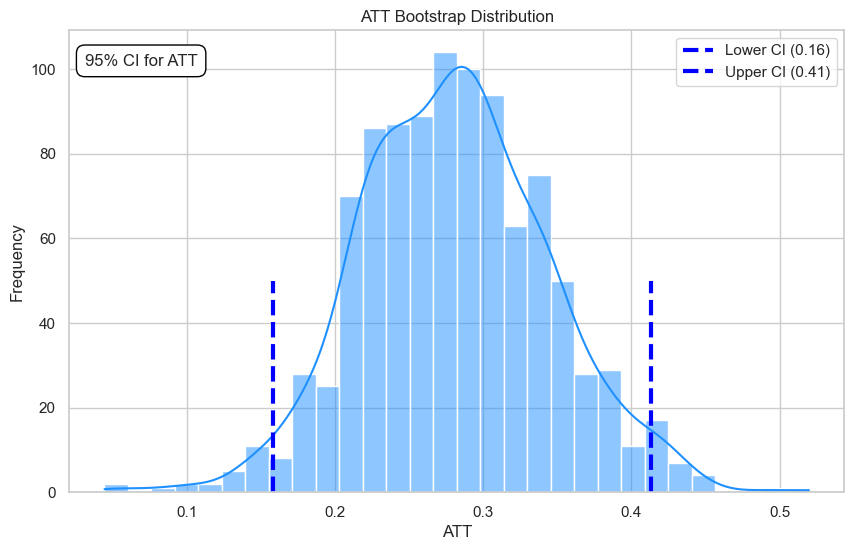

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(bootstrap_ates, bins=30, kde=True, color='dodgerblue')
plt.vlines(np.percentile(bootstrap_ates, 2.5), 0, 50, colors='blue', linestyles='--', label=f'Lower CI ({np.percentile(bootstrap_ates, 2.5):.2f})', linewidth=3)
plt.vlines(np.percentile(bootstrap_ates, 97.5), 0, 50, colors='blue', linestyles='--', label=f'Upper CI ({np.percentile(bootstrap_ates, 97.5):.2f})', linewidth=3)
plt.title('ATT Bootstrap Distribution')
plt.xlabel('ATT')
plt.ylabel('Frequency')
plt.legend()
plt.text(x=0.02, y=0.95, s='95% CI for ATT', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.text(x=0.02, y=0.95, s='95% CI for ATT', transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

plt.show()

***We see that the confidence interval does not include the value 0. So we can conclude with 95% confidence that playing at home positively affects the goal difference.***

### 3.4.3 Build counterfactual for the control group (not playing at home)

In [ ]:
#Match observations
matched_treated, matched_control = match_control_on_propensity_scores(data, propensity_scores, T)

In [ ]:
# Check how many different observations in the treated group can be matched with 7027 observations in the control group
unique_df = matched_treated.drop_duplicates()
num_unique_rows = unique_df.shape[0]

print("Observations:", num_unique_rows)

Observations: 2953


#### Review the Quality of Matching

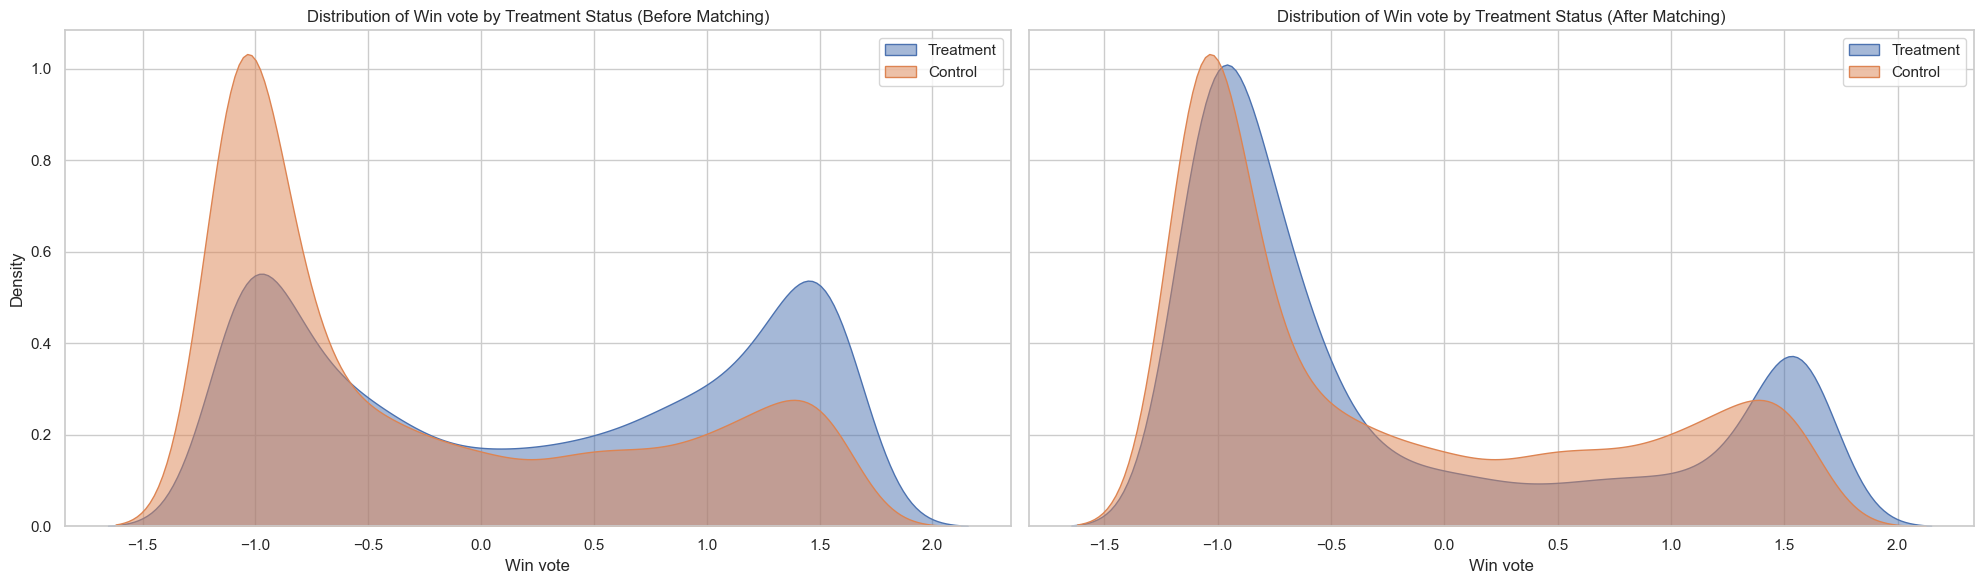

In [ ]:
numeric_vars = ['Win vote']

for var in numeric_vars:
    fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharey=True)

    # Data before matching
    sns.kdeplot(data[data['Pitch'] == 1][var], label='Treatment', fill=True, alpha=0.5, ax=axes[0])
    sns.kdeplot(data[data['Pitch'] == 0][var], label='Control', fill=True, alpha=0.5, ax=axes[0])
    axes[0].set_title(f'Distribution of {var} by Treatment Status (Before Matching)')
    axes[0].set_xlabel(var)
    axes[0].set_ylabel('Density')
    axes[0].legend()

    # Data after matching
    sns.kdeplot(matched_treated[var], label='Treatment', fill=True, alpha=0.5, ax=axes[1])
    sns.kdeplot(matched_control[var], label='Control', fill=True, alpha=0.5, ax=axes[1])
    axes[1].set_title(f'Distribution of {var} by Treatment Status (After Matching)')
    axes[1].set_xlabel(var)
    axes[1].set_ylabel('Density')
    axes[1].legend()

    # Display the plot
    plt.tight_layout()
    plt.show()

**We see that the distribution of attributes has matched better after matching, meeting the prerequisite conditions of balance between the two groups, so we will proceed to calculate the average treatment effect on the control group (ATC) of receiving treatment (playing at home)**

#### Test the initial hypothesis using ATC

In [ ]:
# Calculate ATC
atc = calculate_ate_from_matched(matched_treated, matched_control, Y)
print(f"ATC estimated by PSM: {atc}")

ATC ước tính bằng PSM: 0.30605285592497866


#### Use t-test to check if there is a difference in the mean results of the two groups

**Hypothesis testing:**  
**H0 : no difference in mean between the two groups**  
**H1 : there is a difference in mean between the two groups  
Based on the p-value to decide whether to accept or reject H0**

In [ ]:
# use t-test on the two matched samples
treatment_group = matched_treated[Y]
control_group = matched_control[Y]

mean_treatment = treatment_group.mean()
mean_control = control_group.mean()
std_treatment = treatment_group.std()
std_control = control_group.std()

print("Mean (Treatment):", mean_treatment)
print("Mean (Control):", mean_control)
print("Std (Treatment):", std_treatment)
print("Std (Control):", std_control)

# Perform two-sample t-test
t_stat, p_value = stats.ttest_ind(treatment_group, control_group)

print("T-statistic:", t_stat)
print("P-value:", p_value)

# Hypothesis testing
alpha = 0.05  # Significance level 5%

if p_value < alpha:
    print("\nWe reject the null hypothesis -> Treatment has an effect on the outcome variable.")
else:
    print("\nWe cannot reject the null hypothesis -> Treatment does not have a significant effect on the outcome variable.")


Mean (Treatment): 0.013213981244671782
Mean (Control): -0.2928388746803069
Std (Treatment): 1.8910862875195324
Std (Control): 1.8535042637900259
T-statistic: 9.696385125007394
P-value: 3.6643744803798994e-22

Chúng ta bác bỏ giả thuyết H0 -> Treatment có ảnh hưởng đến biến kết quả.


>**So the factor of playing at home and away affects the result**

#### Check if the treatment has a positive or negative effect on the result

#### Calculate 95% confidence interval for ATC

In [ ]:
# calculate 95% confidence interval for ATC
confidence_interval, bootstrap_ates = bootstrap_psm_confidence_interval(data, X, T, Y,  match_func=match_control_on_propensity_scores)
print("Confidence interval for ATC:", confidence_interval)

Bootstrap Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Khoảng tin cậy cho ATC: [0.14883965 0.41294451]


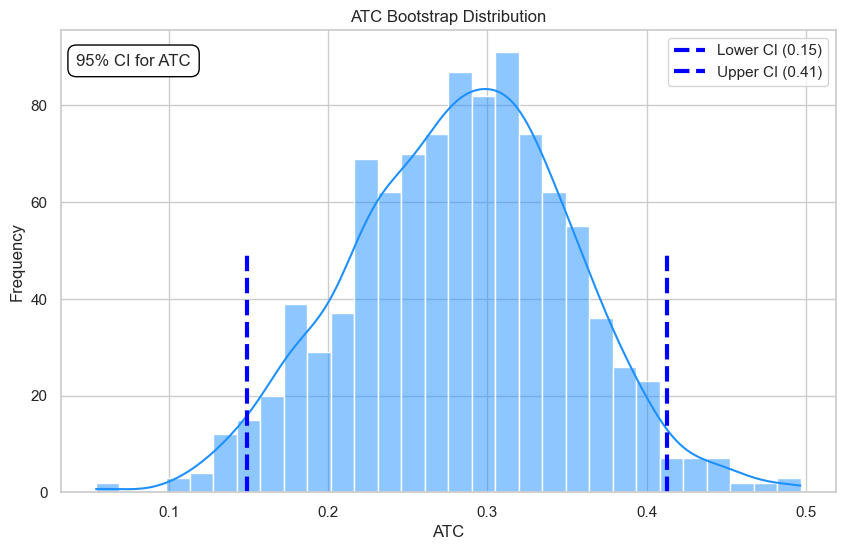

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(bootstrap_ates, bins=30, kde=True, color='dodgerblue')
plt.vlines(np.percentile(bootstrap_ates, 2.5), 0, 50, colors='blue', linestyles='--', label=f'Lower CI ({np.percentile(bootstrap_ates, 2.5):.2f})', linewidth=3)
plt.vlines(np.percentile(bootstrap_ates, 97.5), 0, 50, colors='blue', linestyles='--', label=f'Upper CI ({np.percentile(bootstrap_ates, 97.5):.2f})', linewidth=3)
plt.title('ATC Bootstrap Distribution')
plt.xlabel('ATC')
plt.ylabel('Frequency')
plt.legend()
plt.text(x=0.02, y=0.95, s='95% CI for ATC', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.text(x=0.02, y=0.95, s='95% CI for ATC', transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

plt.show()

***We see that the confidence interval does not include the value 0. So we can conclude with 95% confidence that playing at home positively affects the goal difference.***

## 3.5 Conclusion
**Confidence interval for ATT:** shows that the treatment effect (playing at home) for observations that actually received treatment (matches where teams played at home) is positive and lies in the range **[0.158, 0.413]** with 95% confidence.

**Confidence interval for ATC:** also indicates that the treatment effect (playing at home) for teams that did not play at home is positive and lies in the range [0.149, 0.413] with 95% confidence.

***With the confidence intervals for both ATT and ATC lying above 0, and observing that both distributions of ATT and ATC lie in the positive range, we can conclude that playing at home positively affects the goal difference of the team in that match.***

# **4. Summary**

## 4.1 Implementation Method

### Using Selenium to scrape raw data from the web:

  - Choose website: https://www.transfermarkt.com
  - Select country, automatically choose the top league of that country
  - Select the most recent years, excluding the 24/25 or 2024 season as it has not yet concluded.
  - Navigate to the matchday overviews page of that league and scrape data.
  - Navigate to the matchday report page of each match to get additional data on line-ups of each team.
  - Continuously write data to a JSON file.

### Using LLM to extract structured data from raw data

* Divided into 2 stages:
  1. Extract information about a match (including both home and away teams)
  2. Extract information about each team's match from the information about the entire match above
* **Stage 1**: use the **Langchain** framework to create a processing chain, including the following steps:
  * Create a **Match** class inheriting from the BaseModel class of the Pydantic_v1 package to define and explain the information to be extracted from a match.
  * Create a **parser** object of the PydanticOutputParser class to return an object based on the Match class from the extracted information.
  * Create a **prompt template** to pass input and extraction instructions to the model.
  * Choose a language model **llm**.
  * Create a chain: **prompt template** | **llm** | **parser**.
  * Save information about the Match object from the **output** of the **chain**
* **Stage 2**:
  * Create a **TeamMatch** object to store information from the **Match** object
  * Iterate through the **Match** objects extracted from the previous stage to extract **TeamMatch** objects.
  * Save information about **TeamMatch** objects to a CSV file for later use.



### How to perform Causal Inference

#### **Methods used in the Causal Inference section:**

1.  **Propensity score matching (PSM)**
Find the treatment group and control group that are similar in the overall sample using statistical models.
Build a propensity score.
The propensity score is the probability of receiving treatment for an observation. It is the probability of a team playing at home.
Use Logistic regression to calculate the propensity score, then match observations with similar propensity scores.


*  PSM combines the methods of propensity score and matching
*   Steps to perform propensity score matching:



>>*  1.Estimate the model P(Di = 1|X) = f (Xi) using logit or probit regression.
*   2.Estimate the probability of participating in the program for each observation i at values Xi, called the propensity score.
*   3.Match the treatment and control groups based on similar values of p(Di = 1|X). There are different matching methods.
*   4.Check balance conditions. Use the common support region and distribution of covariates.
* 5.Estimate ATT and ATC from the matched groups.













#### **Steps to perform the Causal Inference section:**
- Perform **Data Processing** to prepare all variables for causal inference: Section 3.2 (detailed steps)
- Perform **Propensity Score Matching (PSM)** (Section 3.4):
>- Estimate propensity scores using LogisticRegression with the function "**estimate_propensity_scores**"
>- Perform matching between treatment and control groups based on propensity score using two functions "match_control_on_propensity_scores" (T=0) and "match_treated_on_propensity_scores" (T=1)
>-Calculate the average treatment effect between the two groups (ATT and ATC) using the function "calculate_ate_from_matched"
- Based on the hypothesis, identify the variables: 'Pitch' as the treatment variable (T), 'Difference of score' as the dependent variable (Y), and the remaining attributes as covariates (X)
>- Estimate Propensity Scores and plot the distribution of Propensity Scores to see the common support region. Since the common support region is large, we can apply PSM to find the treated and control groups
>- Calculate ATT, ATC, and CI based on ATT, ATC in two separate parts
>>- Build counterfactual for the treated group (playing at home)
>>>- Calculate ATT and use t.test to check if the two means are different. Based on the results, we will reject H0.
>>>-Then, calculate the 95% confidence interval for ATT using the bootstrap method. Plot the graph to show the confidence interval.
>>- Build counterfactual for the control group (not playing at home)
>>>- Calculate ATC and use t.test to check if the two means are different. Based on the results, we will reject H0.
>>>-Then, calculate the 95% confidence interval for ATC using the bootstrap method. Plot the graph to show the confidence interval.


## 4.2 Results

- Based on the analysis and calculated confidence intervals, we reject the null hypothesis H0: playing at home does not affect the goal difference of the team in that match.

- **Conclusion:** Playing at home has a positive and statistically significant effect on the goal difference of the team. The team playing at home can increase the goal difference by 0.149 to 0.413 goals.



## 4.3 Difficulties encountered during the project

* Scraping a large amount of data takes time and requires a stable internet connection.
* The structure of the website is not fixed and may change over time, requiring code updates whenever the website changes.
* When using LLM, the prompt needs to be adjusted based on the model being used, as different models have different capabilities in understanding and processing requests.
* When extracting data with LLM, there is no tool to automatically check and control the accuracy of the output, so this must be done manually.
* It takes time to research and choose the appropriate model for hypothesis testing.